### Initial Imports

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, gamma, lognorm, weibull_min, gaussian_kde, skew, genpareto
from scipy.interpolate import make_interp_spline
import seaborn as sns
from copulas.multivariate import GaussianMultivariate
from sklearn.preprocessing import QuantileTransformer
import pymannkendall as mk
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import itertools
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Question 1

In [19]:
lee_ferry = pd.read_csv('LeesFerry-monflows-1906-2016.txt', delimiter=' ', header=None)
lee_ferry.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
lee_ferry = lee_ferry.set_index('Year')
lee_ferry

Jan     Feb      Mar      Apr      May     June     July      Aug  \
Year                                                                         
1906  244314  292534   678174  1204640  3635101  5014167  2950460  1605086   
1907  356760  377349   789130  1465838  2702179  5967232  5103491  1920787   
1908  276192  379543   664762  1041224  1595614  2922360  1924283  1117477   
1909  378989  317458   763721  1120492  3349297  7203254  4109919  1880422   
1910  289322  493565  1403871  1730475  3298793  3101705  1373125   866631   
...      ...     ...      ...      ...      ...      ...      ...      ...   
2012  381442  384326   733774  1222586  1362700  1079225   744933   636178   
2013  214584  289629   359208   546319  1965060  1964812   874772   727596   
2014  309820  374229   562920  1269132  2932034  3933465  1527985   899893   
2015  409191  526665   704518   852287  2115387  4265586  1651282   669822   
2016  360703  448837   679140  1099567  2967581  3910287  1342044   609946   

          Sep     Oct     Nov     Dec  
Year                                   
1906  1503159  739807  503006  353312  
1907   955414  608812  377467  268130  
1908   598088  483627  395707  312145  
1909  1526396  680646  489990  377548  
1910   630999  616468  445769  345922  
...       ...     ...     ...     ...  
2012   375426  344045  314021  225025  
2013  1147550  647503  522374  337385  
2014   788861  881584  466760  423745  
2015   477521  625779  442955  317416  
2016   485507  546633  426289  345163  

[111 rows x 12 columns]

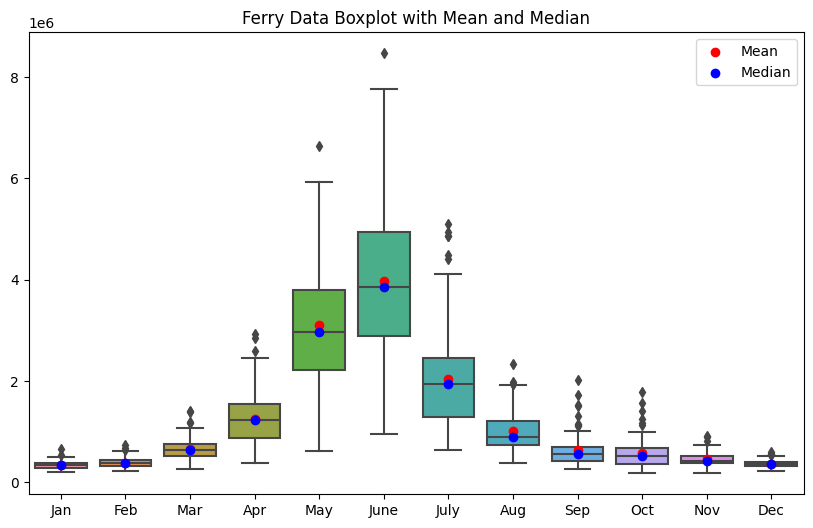

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=lee_ferry)
means = lee_ferry.mean()
medians = lee_ferry.median()

# Plot means and medians
plt.scatter(range(len(means)), means, color='red', label='Mean', zorder=3)
plt.scatter(range(len(medians)), medians, color='blue', label='Median', zorder=3)
plt.title('Ferry Data Boxplot with Mean and Median')
plt.legend(loc='upper right')
plt.show()


### April, May, June, and July have the largest IQR's in all the data, as well as the largest spread in max and min values. I.e., the data for these months is the most variable 

## Question 2

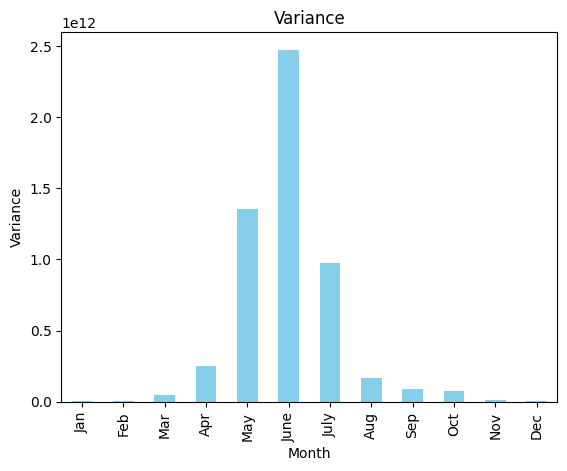

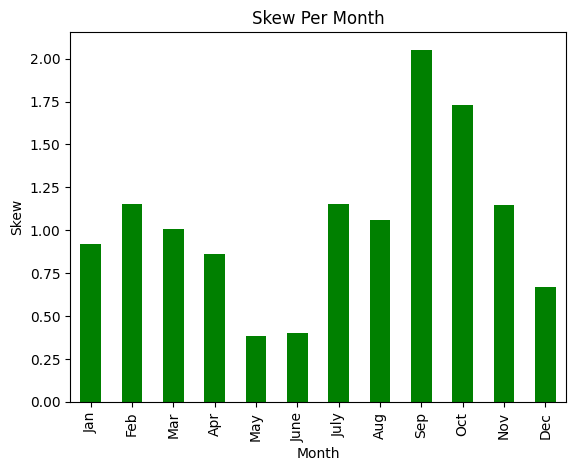

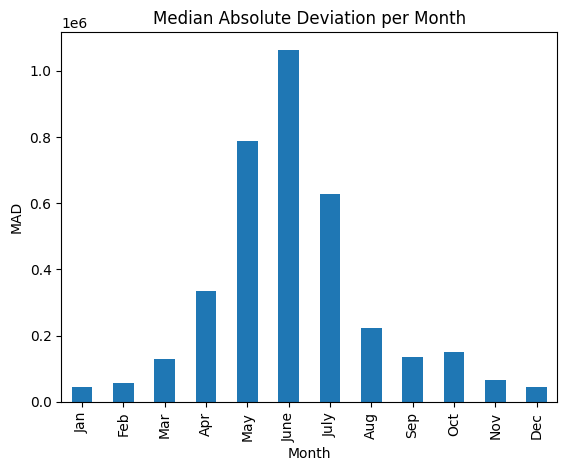

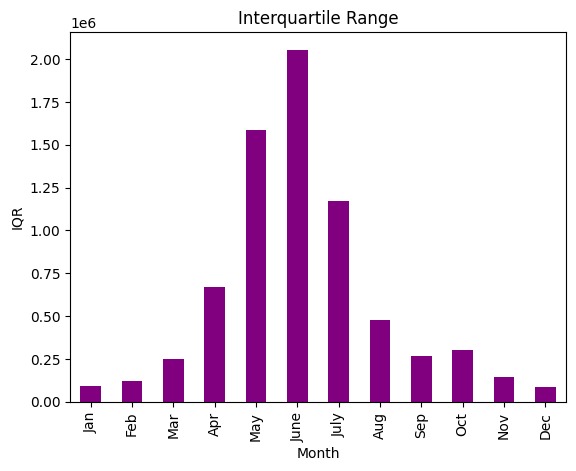

In [21]:
variance = lee_ferry.var()
variance.plot(kind='bar', color='skyblue', title='Variance', xlabel='Month', ylabel='Variance')
plt.show()

# Skewness
skew_values = lee_ferry.apply(lambda col: skew(col.dropna()))
skew_values.plot(kind='bar', color='green', title='Skew Per Month', xlabel='Month', ylabel='Skew')
plt.show()

# Median Absolute Deviation
mad_values = lee_ferry.apply(lambda col: np.median(np.abs(col - np.median(col))))
mad_values.plot(kind='bar', title='Median Absolute Deviation per Month', xlabel='Month', ylabel='MAD')
plt.show()

# Interquartile Range
iqr_values = lee_ferry.apply(lambda col: col.quantile(0.75) - col.quantile(0.25))
iqr_values.plot(kind='bar', color='purple', title='Interquartile Range', xlabel='Month', ylabel='IQR')
plt.show()


#### September and October has the most skew, may, june, july have the greatest IQR, MAD, and variance

## Question 3

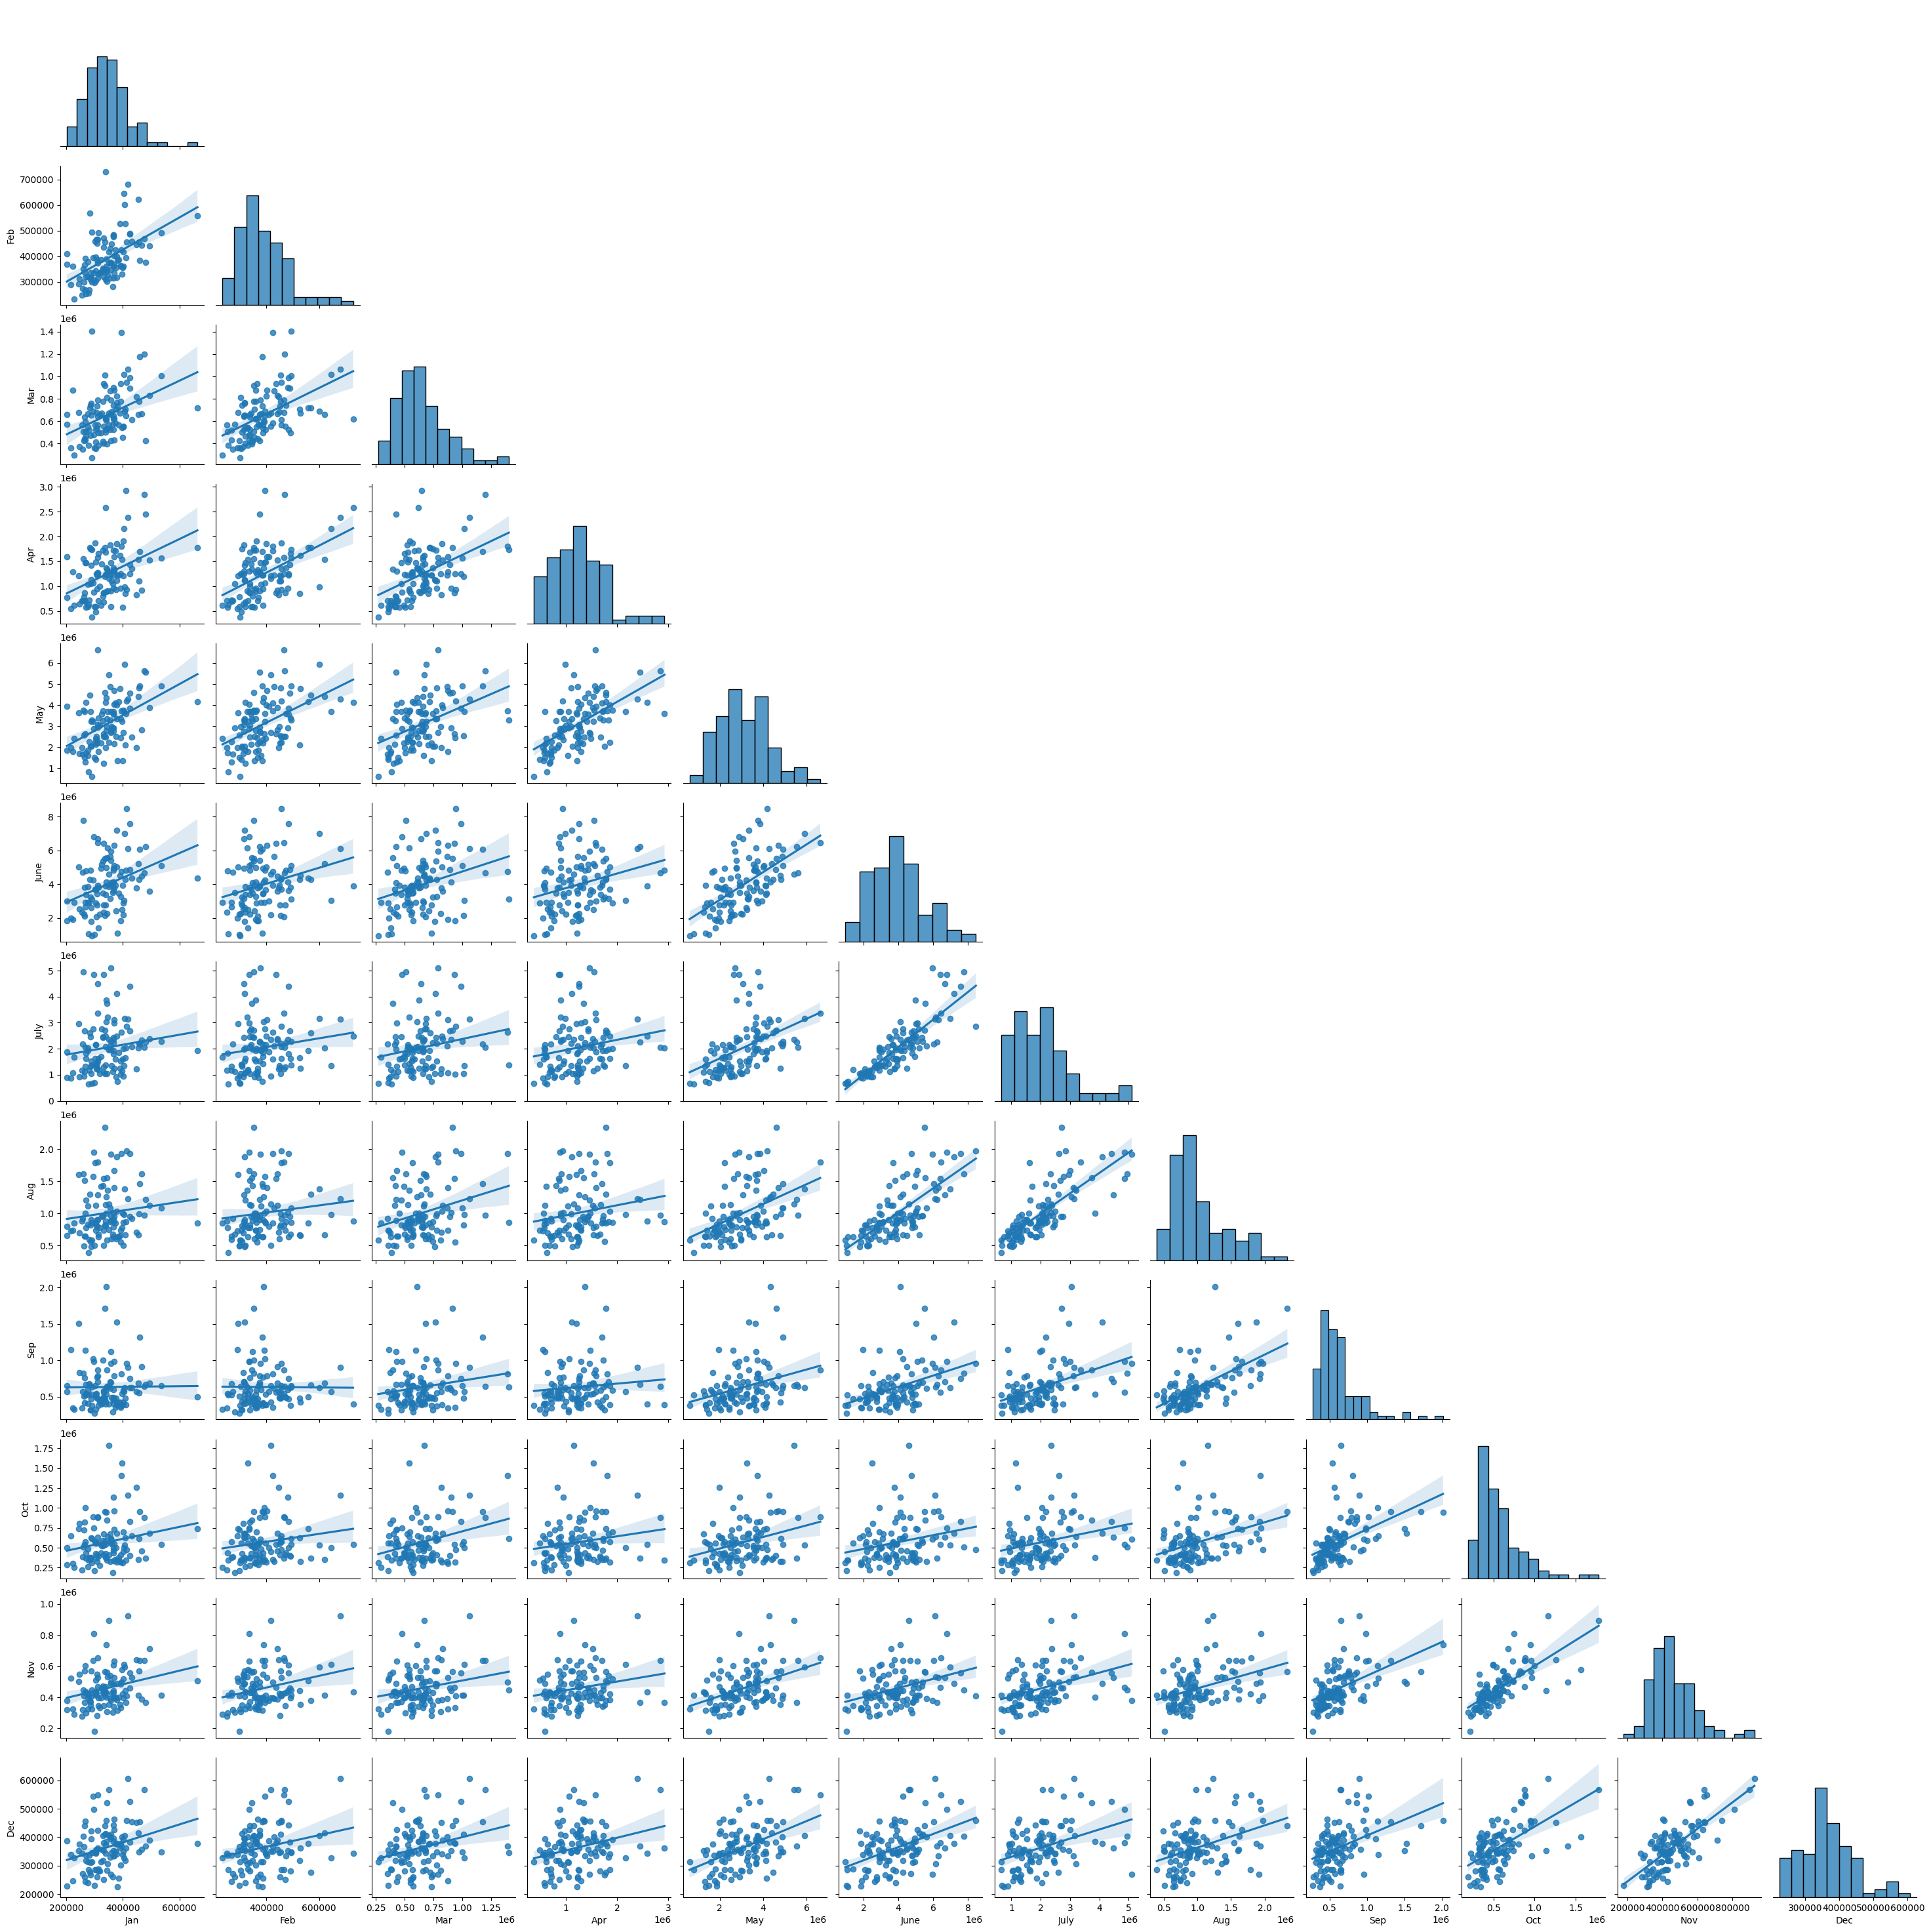

In [22]:
sns.pairplot(lee_ferry, kind = 'reg', corner = True)

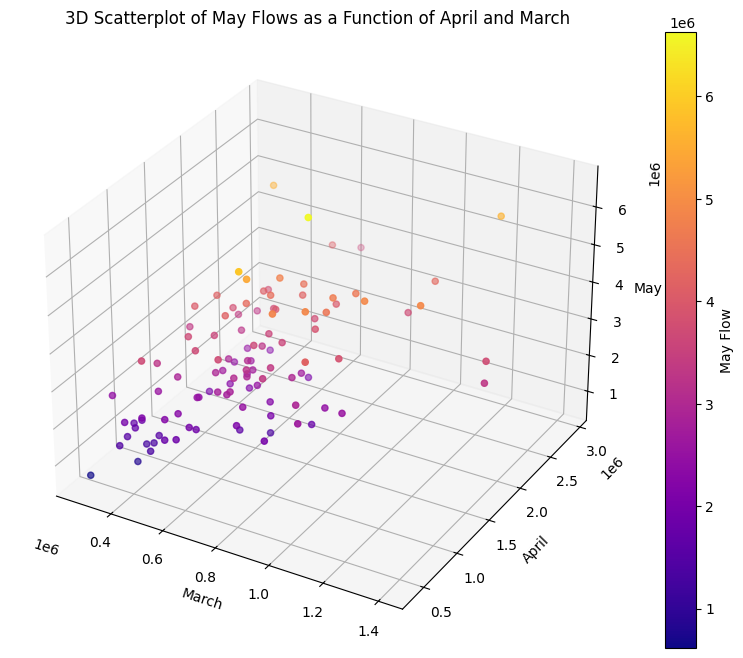

In [23]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(lee_ferry['Mar'], lee_ferry['Apr'], lee_ferry['May'], 
                     c=lee_ferry['May'], cmap='plasma')
fig.colorbar(scatter, label='May Flow')

ax.set_xlabel('March')
ax.set_ylabel('April')
ax.set_zlabel('May')

plt.title('3D Scatterplot of May Flows as a Function of April and March')
plt.show()

#### There appears to be varying degrees of trends throughout the pairplot. Notably, Dec as a function of Nov and July as a funciton of June have really strong positive correlations. As far as the 3D scatter goes, it would appear that May streamflow is positively correlated as a function of March and Apirl streamflow. 

## Question 4

# May

In [24]:
may = np.array(lee_ferry['May'])
may_pandas = pd.DataFrame(lee_ferry['May'])
may

array([3635101, 2702179, 1595614, 3349297, 3298793, 2924637, 3684152,
       3270773, 4685651, 2427137, 3736188, 3763312, 2760606, 3231443,
       5917499, 4180109, 4874849, 4029114, 3384372, 2624348, 3686355,
       4348392, 4821916, 4602167, 2225165, 1515196, 4465792, 1743460,
       1509729, 1659496, 4139077, 3944714, 3725399, 2975185, 2559692,
       5436441, 3586298, 2483874, 3684541, 3255617, 1979996, 3702981,
       4108490, 3564293, 2239709, 2133211, 5554490, 1342116, 1804002,
       1993763, 2926653, 2889416, 4780048, 1422316, 2032109, 1695847,
       4111052, 1860875, 2430315, 3336138, 2431492, 1846928, 2211325,
       3765327, 3676415, 2483329, 1982707, 4575588, 3351494, 2780986,
       2512577,  616062, 2767077, 4004959, 4411471, 1246368, 3217893,
       3844250, 6628365, 5606346, 4287464, 3702789, 2199411, 1778580,
       1309652, 2361798, 2497785, 4904073, 2495467, 2642353, 3562190,
       4911189, 3878483, 2833327, 2690228, 3040039,  820372, 2267512,
       2039820, 4162

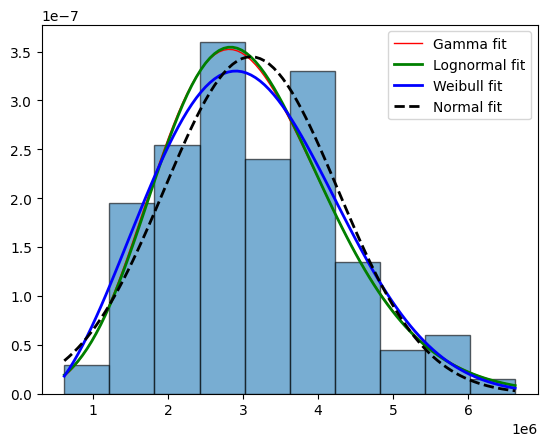

In [25]:
#May
# may = np.array(lee_ferry['May'])
# may_pandas = pd.DataFrame(lee_ferry['May'])


#normal
mean_n, std_n = norm.fit(may)
#gamma
g_fit = gamma.fit(may)
#lognormal
ln_fit = lognorm.fit(may)
#weibull
wb_fit = weibull_min.fit(may)


x = np.linspace(min(may), max(may), 100) #This creates an array of 100 evenly spaced datapoints within the min and max of the given dataset. This then gets fed into the gamma parameters to generate the PDF
plt.hist(may, density=True, alpha = 0.6, edgecolor = 'black')
plt.plot(x, gamma.pdf(x, *g_fit), 'r-', lw=1, label="Gamma fit")
plt.plot(x, lognorm.pdf(x, *ln_fit), 'g-', lw=2, label="Lognormal fit")
plt.plot(x, weibull_min.pdf(x, *wb_fit), 'b-', lw=2, label="Weibull fit")
plt.plot(x, norm.pdf(x, mean_n, std_n), 'k--', lw=2, label="Normal fit")

plt.legend()
plt.show()

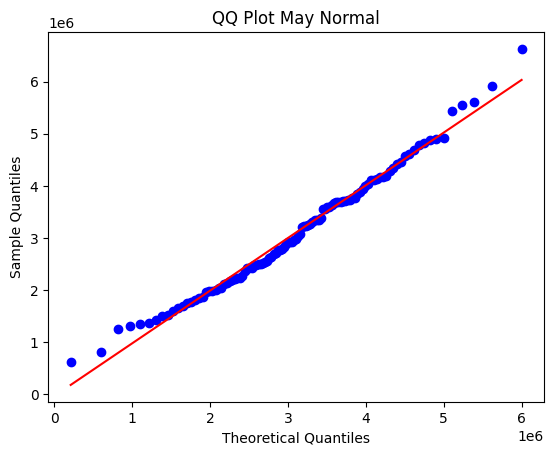

In [26]:
stats.probplot(may, dist="norm", sparams=(mean_n, std_n),plot=plt)
plt.title("QQ Plot May Normal")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

Text(0.5, 1.0, 'QQ Lognormal Distribution')

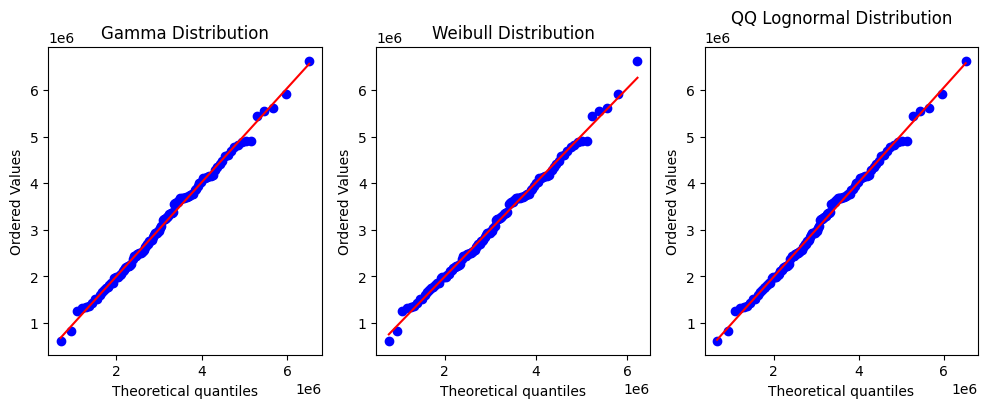

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# QQ plot for Gamma distribution
stats.probplot(may, dist="gamma", sparams=g_fit, plot=axs[0])  # shape=2 for Gamma
axs[0].set_title("Gamma Distribution")

# QQ plot for Weibull distribution
stats.probplot(may, dist="weibull_min", sparams=wb_fit, plot=axs[1])  # shape=1.5 for Weibull
axs[1].set_title("Weibull Distribution")

# QQ plot for Lognormal distribution
stats.probplot(may, dist="lognorm", sparams=ln_fit, plot=axs[2])  # shape=0.5 for Lognormal
axs[2].set_title("QQ Lognormal Distribution")

In [28]:
statistic, p_value = stats.kstest(may, 'norm', args=(mean_n, std_n))
print(f"Normal K-S Statistic: {statistic}")
print(f"Normal P-value: {p_value}")

statistic_gamma, p_value_gamma = stats.kstest(may, 'gamma', args=(g_fit))
print(f"Gamma K-S Statistic: {statistic_gamma}")
print(f"Gamma P-value: {p_value_gamma}")

# Perform the K-S test comparing the sample to the fitted Weibull distribution
statistic_weibull, p_value_weibull = stats.kstest(may, 'weibull_min', args=(wb_fit))
print(f"Weibull K-S Statistic: {statistic_weibull}")
print(f"Weibull P-value: {p_value_weibull}")

# Perform the K-S test comparing the sample to the fitted Lognormal distribution
statistic_lognormal, p_value_lognormal = stats.kstest(may, 'lognorm', args=ln_fit)
print(f"Lognormal K-S Statistic: {statistic_lognormal}")
print(f"Lognormal P-value: {p_value_lognormal}")

Normal K-S Statistic: 0.06007286857476535
Normal P-value: 0.7952783900571778
Gamma K-S Statistic: 0.06541986067118755
Gamma P-value: 0.7040221058892594
Weibull K-S Statistic: 0.051319455258425295
Weibull P-value: 0.9172135633668114
Lognormal K-S Statistic: 0.0656601191463071
Lognormal P-value: 0.6997838322906176


Text(0.5, 1.0, 'May KDE Estimation')

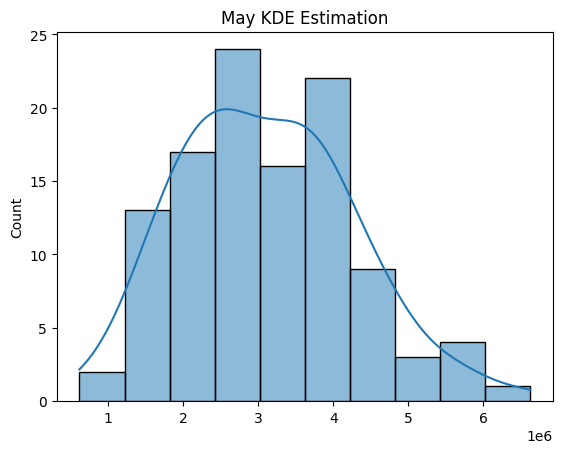

In [29]:
sns.histplot(data = may, kde=True)
plt.title('May KDE Estimation')

## Aug

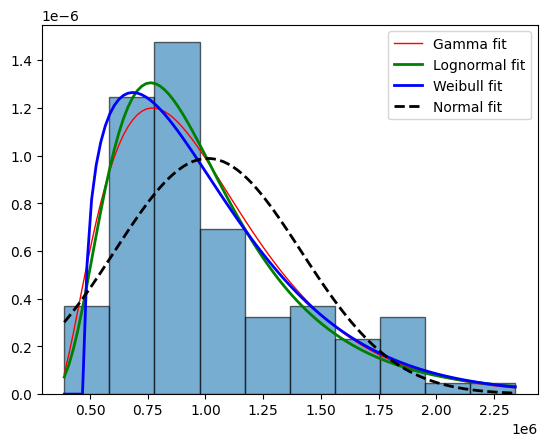

In [30]:
##Aug
Aug = np.array(lee_ferry['Aug'])
#normal
mean_n, std_n = norm.fit(Aug)
#gamma
g_fit = gamma.fit(Aug)
#lognormal
ln_fit = lognorm.fit(Aug)
#weibull
wb_fit = weibull_min.fit(Aug)

x = np.linspace(min(Aug), max(Aug), 100) #This creates an array of 100 evenly spaced datapoints within the min and max of the given dataset. This then gets fed into the gamma parameters to generate the PDF
plt.hist(Aug, density=True, alpha = 0.6, edgecolor = 'black')
plt.plot(x, gamma.pdf(x, *g_fit), 'r-', lw=1, label="Gamma fit")
plt.plot(x, lognorm.pdf(x, *ln_fit), 'g-', lw=2, label="Lognormal fit")
plt.plot(x, weibull_min.pdf(x, *wb_fit), 'b-', lw=2, label="Weibull fit")
plt.plot(x, norm.pdf(x, mean_n, std_n), 'k--', lw=2, label="Normal fit")

plt.legend()
plt.show()

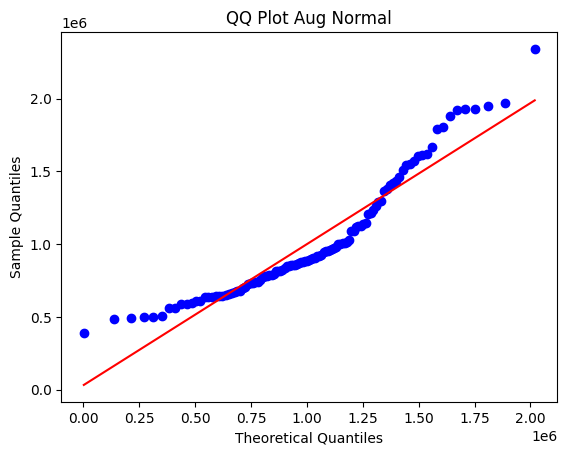

In [31]:
stats.probplot(Aug, dist="norm", sparams=(mean_n, std_n),plot=plt)
plt.title("QQ Plot Aug Normal")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

Text(0.5, 1.0, 'QQ Lognormal Distribution')

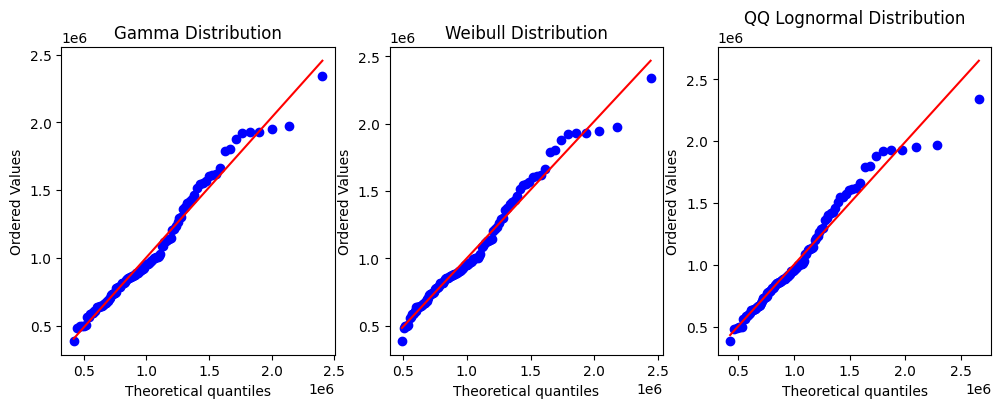

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# QQ plot for Gamma distribution
stats.probplot(Aug, dist="gamma", sparams=g_fit, plot=axs[0])  # shape=2 for Gamma
axs[0].set_title("Gamma Distribution")

# QQ plot for Weibull distribution
stats.probplot(Aug, dist="weibull_min", sparams=wb_fit, plot=axs[1])  # shape=1.5 for Weibull
axs[1].set_title("Weibull Distribution")

# QQ plot for Lognormal distribution
stats.probplot(Aug, dist="lognorm", sparams=ln_fit, plot=axs[2])  # shape=0.5 for Lognormal
axs[2].set_title("QQ Lognormal Distribution")

In [33]:
statistic, p_value = stats.kstest(Aug, 'norm', args=(mean_n, std_n))
print(f"Normal K-S Statistic: {statistic}")
print(f"Normal P-value: {p_value}")

statistic_gamma, p_value_gamma = stats.kstest(Aug, 'gamma', args=(g_fit))
print(f"Gamma K-S Statistic: {statistic_gamma}")
print(f"Gamma P-value: {p_value_gamma}")

# Perform the K-S test comparing the sample to the fitted Weibull distribution
statistic_weibull, p_value_weibull = stats.kstest(Aug, 'weibull_min', args=(wb_fit))
print(f"Weibull K-S Statistic: {statistic_weibull}")
print(f"Weibull P-value: {p_value_weibull}")

# Perform the K-S test comparing the sample to the fitted Lognormal distribution
statistic_lognormal, p_value_lognormal = stats.kstest(Aug, 'lognorm', args=ln_fit)
print(f"Lognormal K-S Statistic: {statistic_lognormal}")
print(f"Lognormal P-value: {p_value_lognormal}")

Normal K-S Statistic: 0.1623153538906797
Normal P-value: 0.0050540268644102505
Gamma K-S Statistic: 0.08203681345518143
Gamma P-value: 0.4213310485865376
Weibull K-S Statistic: 0.07332568706302134
Weibull P-value: 0.5641620179826017
Lognormal K-S Statistic: 0.0634161265536094
Lognormal P-value: 0.7390286494767206


Text(0.5, 1.0, 'Aug KDE Estimation')

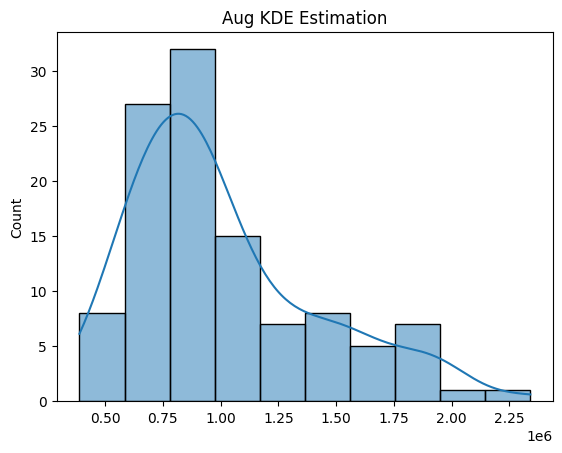

In [34]:
sns.histplot(data = Aug, kde=True)
plt.title('Aug KDE Estimation')

## Dec

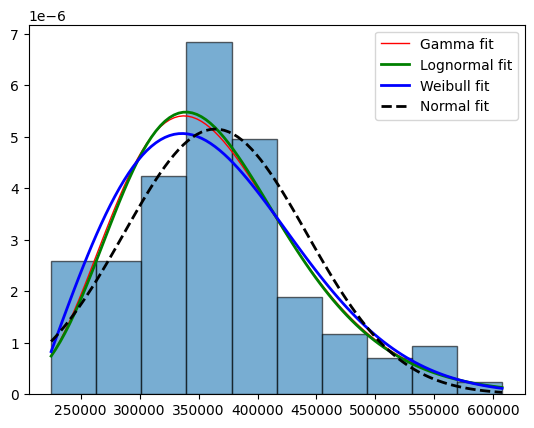

In [35]:
#Dec
Dec = np.array(lee_ferry['Dec'])
#normal
mean_n, std_n = norm.fit(Dec)
#gamma
g_fit = gamma.fit(Dec)
#lognormal
ln_fit = lognorm.fit(Dec)
#weibull
wb_fit = weibull_min.fit(Dec)

x = np.linspace(min(Dec), max(Dec), 100) #This creates an array of 100 evenly spaced datapoints within the min and max of the given dataset. This then gets fed into the gamma parameters to generate the PDF
plt.hist(Dec, density=True, alpha = 0.6, edgecolor = 'black')
plt.plot(x, gamma.pdf(x, *g_fit), 'r-', lw=1, label="Gamma fit")
plt.plot(x, lognorm.pdf(x, *ln_fit), 'g-', lw=2, label="Lognormal fit")
plt.plot(x, weibull_min.pdf(x, *wb_fit), 'b-', lw=2, label="Weibull fit")
plt.plot(x, norm.pdf(x, mean_n, std_n), 'k--', lw=2, label="Normal fit")

plt.legend()
plt.show()

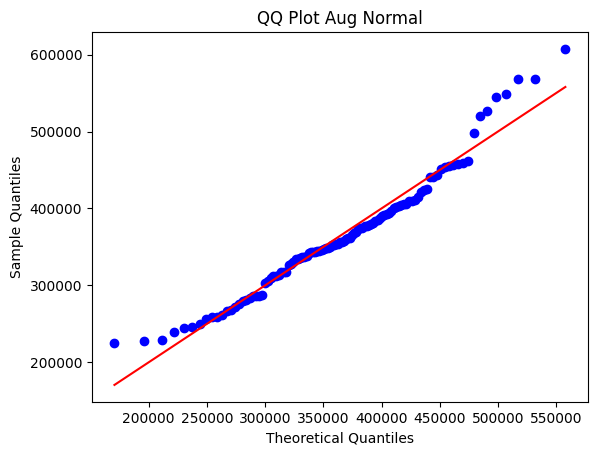

In [36]:
stats.probplot(Dec, dist="norm", sparams=(mean_n, std_n),plot=plt)
plt.title("QQ Plot Aug Normal")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

Text(0.5, 1.0, 'QQ Lognormal Distribution')

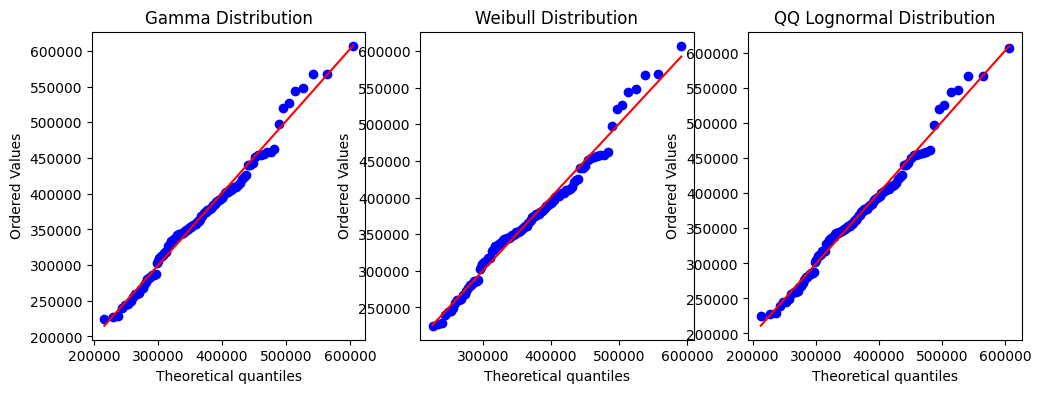

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# QQ plot for Gamma distribution
stats.probplot(Dec, dist="gamma", sparams=g_fit, plot=axs[0])  # shape=2 for Gamma
axs[0].set_title("Gamma Distribution")

# QQ plot for Weibull distribution
stats.probplot(Dec, dist="weibull_min", sparams=wb_fit, plot=axs[1])  # shape=1.5 for Weibull
axs[1].set_title("Weibull Distribution")

# QQ plot for Lognormal distribution
stats.probplot(Dec, dist="lognorm", sparams=ln_fit, plot=axs[2])  # shape=0.5 for Lognormal
axs[2].set_title("QQ Lognormal Distribution")

In [38]:
statistic, p_value = stats.kstest(Dec, 'norm', args=(mean_n, std_n))
print(f"Normal K-S Statistic: {statistic}")
print("Normal P-value: {p_value}")

statistic_gamma, p_value_gamma = stats.kstest(Dec, 'gamma', args=(g_fit))
print(f"Gamma K-S Statistic: {statistic_gamma}")
print(f"Gamma P-value: {p_value_gamma}")

# Perform the K-S test comparing the sample to the fitted Weibull distribution
statistic_weibull, p_value_weibull = stats.kstest(Dec, 'weibull_min', args=(wb_fit))
print(f"Weibull K-S Statistic: {statistic_weibull}")
print(f"Weibull P-value: {p_value_weibull}")

# Perform the K-S test comparing the sample to the fitted Lognormal distribution
statistic_lognormal, p_value_lognormal = stats.kstest(Dec, 'lognorm', args=ln_fit)
print(f"Lognormal K-S Statistic: {statistic_lognormal}")
print(f"Lognormal P-value: {p_value_lognormal}")

Normal K-S Statistic: 0.07232808930305501
Normal P-value: {p_value}
Gamma K-S Statistic: 0.07770585501742899
Gamma P-value: 0.489934874735357
Weibull K-S Statistic: 0.08447837182427537
Weibull P-value: 0.3851882800457106
Lognormal K-S Statistic: 0.07441616172683779
Lognormal P-value: 0.5453134485209159


Text(0.5, 1.0, 'Dec KDE Estimation')

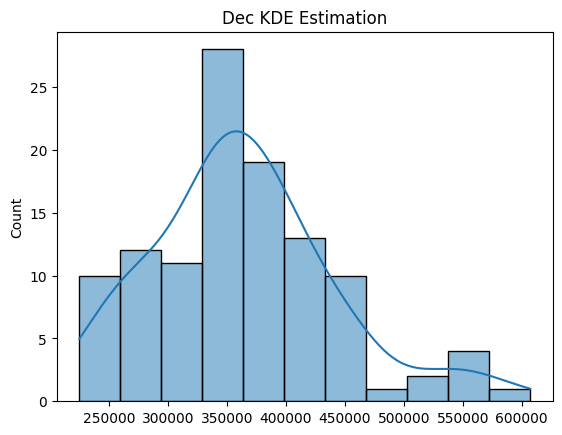

In [39]:
sns.histplot(data = Dec, kde=True)
plt.title('Dec KDE Estimation')

#### August and December appear to have the best non-parametric fits. Gammas has the best Dec. fit and Lognormal has the best Aug fit. In all cases, I would take the parametric fits of the non-parametric. 

### Question 5

In [40]:
may = np.array(lee_ferry['May'])
may_pandas = pd.DataFrame(lee_ferry['May'])
may

array([3635101, 2702179, 1595614, 3349297, 3298793, 2924637, 3684152,
       3270773, 4685651, 2427137, 3736188, 3763312, 2760606, 3231443,
       5917499, 4180109, 4874849, 4029114, 3384372, 2624348, 3686355,
       4348392, 4821916, 4602167, 2225165, 1515196, 4465792, 1743460,
       1509729, 1659496, 4139077, 3944714, 3725399, 2975185, 2559692,
       5436441, 3586298, 2483874, 3684541, 3255617, 1979996, 3702981,
       4108490, 3564293, 2239709, 2133211, 5554490, 1342116, 1804002,
       1993763, 2926653, 2889416, 4780048, 1422316, 2032109, 1695847,
       4111052, 1860875, 2430315, 3336138, 2431492, 1846928, 2211325,
       3765327, 3676415, 2483329, 1982707, 4575588, 3351494, 2780986,
       2512577,  616062, 2767077, 4004959, 4411471, 1246368, 3217893,
       3844250, 6628365, 5606346, 4287464, 3702789, 2199411, 1778580,
       1309652, 2361798, 2497785, 4904073, 2495467, 2642353, 3562190,
       4911189, 3878483, 2833327, 2690228, 3040039,  820372, 2267512,
       2039820, 4162

In [41]:
shape, loc, scale = gamma.fit(may) #get the fit 
N = 500
gamma_mc = np.random.gamma(shape, scale, N) #use the parameters to generate gamma monte carlo samples 
gamma_mc.shape

(500,)

In [42]:
mean = shape * scale 
variance = shape * scale**2
sd= np.sqrt(variance)
skewness = skew(gamma_mc)
iqr = np.percentile(gamma_mc, 75) - np.percentile(gamma_mc, 25) 
median = np.median(gamma_mc)


Text(1.05, 5335060.657033595, 'iqr:  1465995.54')

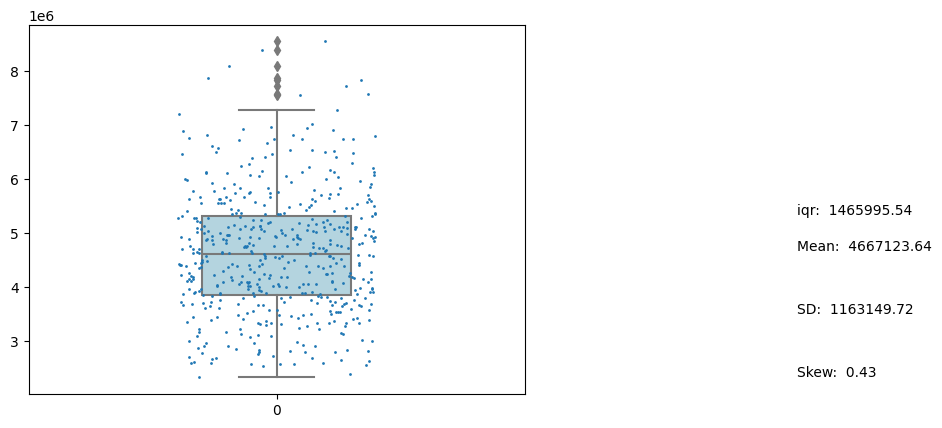

In [43]:
sns.boxplot(data=gamma_mc, color='lightblue', width = 0.3)
sns.stripplot(data=gamma_mc, size=2, jitter = 0.2)
plt.text(1.05, mean, f'Mean: {mean: .2f}') #mean 
plt.text(1.05, mean - sd, f'SD: {sd: .2f}')
plt.text(1.05, mean - 2*sd, f'Skew: {skewness: .2f}')
plt.text(1.05, iqr / 2 + median, f'iqr: {iqr: .2f}')


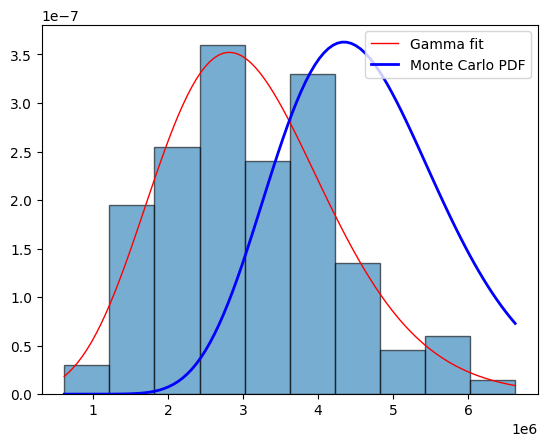

In [44]:
#gamma
g_fit2 = gamma.fit(may)
g_fit3 = gamma.fit(gamma_mc)


x = np.linspace(min(may), max(may), 100) 
plt.hist(may, density=True, alpha = 0.6, edgecolor = 'black')
plt.plot(x, gamma.pdf(x, *g_fit2), 'r-', lw=1, label="Gamma fit")
plt.plot(x, gamma.pdf(x, *g_fit3), 'b-', lw=2, label ='Monte Carlo PDF')

plt.legend()
plt.show()

### Problem 6

In [45]:
def bootstrap(data, num_samples):
    bootstraped_data = []
    for _ in range(num_samples): #does it num_samples amount of time 
        boot_sample = np.random.choice(data, replace=True) #resamples the data with replacement 
        bootstraped_data.append(boot_sample)
    return np.array(bootstraped_data)

data = may 
num_samples = 500
boot_data = bootstrap(may, num_samples)
boot_data

array([2642353, 2702179, 5554490, 2199411, 1342116, 1860875, 2483329,
       2483329, 1659496, 1362700, 1309652, 2483874, 1846928, 1979996,
       3564293, 4108490, 2932034, 2032109,  820372, 1743460, 3844250,
       2483329, 2547942, 1979996, 1246368, 4874849, 2932034, 2225165,
        820372, 1309652, 3702981, 1778580, 4911189, 2767077, 4465792,
       2547942, 1778580, 3736188, 4911189, 1309652, 3702981, 4821916,
       4111052, 3684541, 1422316, 3635101, 1965060, 4874849, 2225165,
       2431492, 1246368, 3336138, 2642353, 2926653, 4780048, 3586298,
       3562190, 3298793, 4602167, 3686355, 2483329, 2760606, 1246368,
       2483329, 3079161, 3040039, 1860875, 4348392, 1860875, 1979996,
       3765327, 1965060, 2115387, 2427137, 2926653, 3586298, 3686355,
       3585225, 2175686,  616062, 3686355, 3878483, 2239709, 4602167,
       2924637, 3255617, 1695847, 2702179, 3564293, 1246368, 3702981,
       2547942, 3702981, 3231443, 3944714, 1965060, 2211325, 2624348,
       3635101, 2926

In [46]:
mean = np.mean(boot_data)
print('Boot Data Mean is:', mean)
# Standard Deviation
std_dev = np.std(boot_data)
print(f"Standard Deviation: {std_dev:.2f}")

# Skew
skewness = stats.skew(boot_data)
print(f"Skewness: {skewness:.2f}")

# IQR
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
print(f"Interquartile Range (IQR): {iqr:.2f}")

Boot Data Mean is: 3057785.44
Standard Deviation: 1078693.83
Skewness: 0.30
Interquartile Range (IQR): 1586543.50


Text(1.05, 5395334.63585226, 'iqr:  1586543.50')

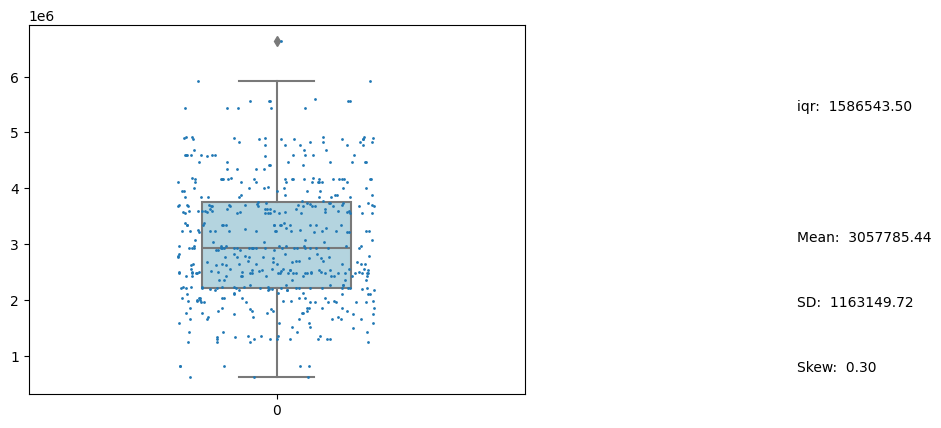

In [47]:
sns.boxplot(data=boot_data, color='lightblue', width = 0.3)
sns.stripplot(data=boot_data, size=2, jitter = 0.2)
plt.text(1.05, mean, f'Mean: {mean: .2f}') #mean 
plt.text(1.05, mean - sd, f'SD: {sd: .2f}')
plt.text(1.05, mean - 2*sd, f'Skew: {skewness: .2f}')
plt.text(1.05, iqr / 2 + median, f'iqr: {iqr: .2f}')


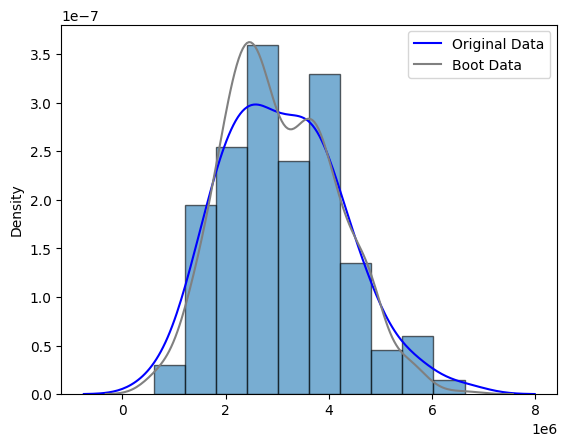

In [48]:
plt.hist(may, density=True, alpha = 0.6, edgecolor = 'black')
sns.kdeplot(may, color='blue', label='Original Data')
sns.kdeplot(boot_data, color='grey', alpha=1, label = 'Boot Data')
plt.legend()

#### The bootstrap approach appears to provide a much better fit than the original Monte Carlo from problem five, and seems to fit the data better than a non-parametric fit

### Problem 7

In [49]:
apr_may_df =lee_ferry[['Apr', 'May']]
apr_may = np.array(apr_may_df)
apr_may

array([[1204640, 3635101],
       [1465838, 2702179],
       [1041224, 1595614],
       [1120492, 3349297],
       [1730475, 3298793],
       [ 951815, 2924637],
       [ 902408, 3684152],
       [1829662, 3270773],
       [1593815, 4685651],
       [1483872, 2427137],
       [1802735, 3736188],
       [1545288, 3763312],
       [ 901047, 2760606],
       [1414719, 3231443],
       [ 983984, 5917499],
       [ 930238, 4180109],
       [1224473, 4874849],
       [1296746, 4029114],
       [1658525, 3384372],
       [1469823, 2624348],
       [1722211, 3686355],
       [1369061, 4348392],
       [1103775, 4821916],
       [1774777, 4602167],
       [1862406, 2225165],
       [ 712221, 1515196],
       [1774718, 4465792],
       [ 579969, 1743460],
       [ 584844, 1509729],
       [ 703982, 1659496],
       [1465536, 4139077],
       [1594216, 3944714],
       [1725164, 3725399],
       [1250651, 2975185],
       [ 780974, 2559692],
       [1151420, 5436441],
       [2925816, 3586298],
 

#### Part A: Fit a Copula and Show the Bivariate Plot Along with the Data

In [50]:
scaler = QuantileTransformer()
transformed = scaler.fit_transform(apr_may)
copula = GaussianMultivariate()
copula.fit(transformed)

/home/anna/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (111). n_quantiles is set to n_samples.
  warnings.warn(
/home/anna/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/home/anna/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)


In [51]:
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([X.ravel(), Y.ravel()])


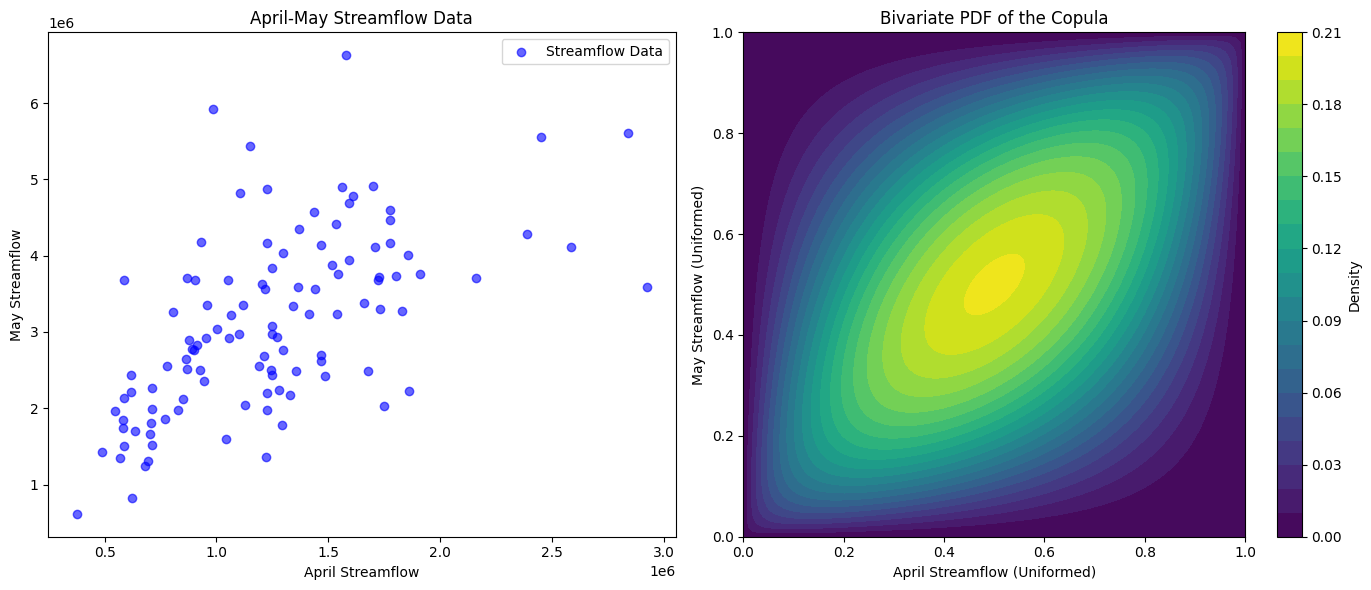

In [52]:
pdf_values = copula.pdf(grid_points).reshape(X.shape)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(apr_may_df['Apr'].values, apr_may_df['May'].values,  color='blue', alpha=0.6, label='Streamflow Data')
axes[0].set_title("April-May Streamflow Data")
axes[0].set_xlabel("April Streamflow")
axes[0].set_ylabel("May Streamflow")
axes[0].legend()

cp = axes[1].contourf(X, Y, pdf_values, cmap='viridis', levels=20)
axes[1].set_title("Bivariate PDF of the Copula")
axes[1].set_xlabel("April Streamflow (Uniformed)")
axes[1].set_ylabel("May Streamflow (Uniformed)")
fig.colorbar(cp, ax=axes[1], label="Density")
plt.tight_layout()
plt.show()

#### Part B: Generate 500 Samples, Boxplot the statistics and PDF's from the simluations along with that of the historic data for April and May Flow

Copula Samples Mean is: 1243747.6244277286
Copula STD is 513479.0738990823
Skewness 0.901907108897402
Interquartile Range (IQR): 667834.6647915236


Text(0.5, 4935980.218248022, 'iqr:  667834.66')

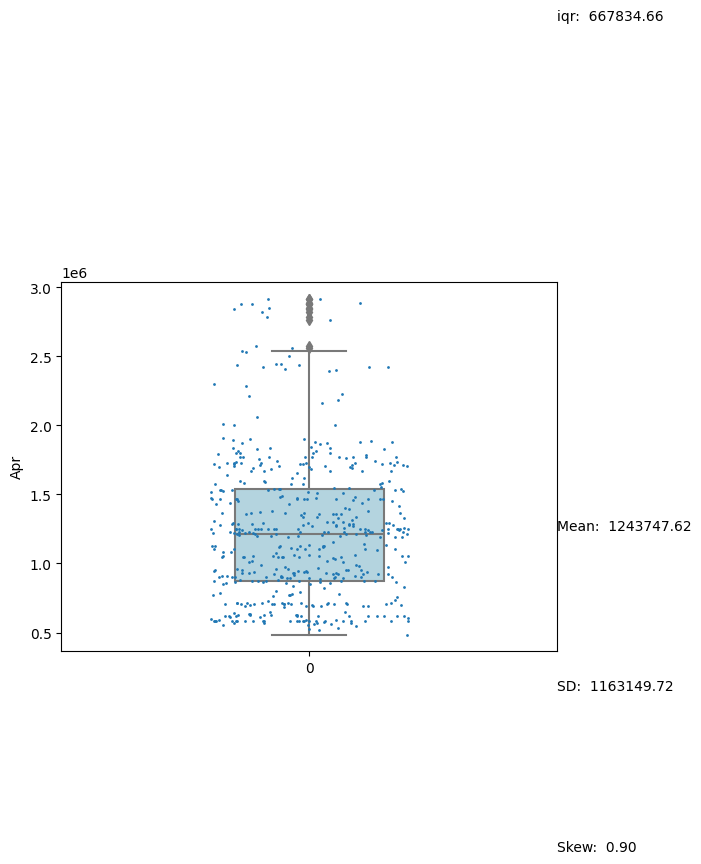

In [53]:
generated_samples = copula.sample(500)
generated_data = scaler.inverse_transform(generated_samples)
generated_data_df = pd.DataFrame(generated_data)
generated_data_df.columns= ['Apr', 'May']
generated_data_df


mean = np.mean(generated_data_df['Apr'])
print('Copula Samples Mean is:', mean)
# Standard Deviation
std_dev = np.std(generated_data_df['Apr'])
print('Copula STD is', std_dev)

# Skew
skewness = stats.skew(generated_data_df['Apr'])
print('Skewness', skewness)

# IQR
q75, q25 = np.percentile(generated_data_df['Apr'], [75, 25])
iqr = q75 - q25
print('Interquartile Range (IQR):', iqr)

sns.boxplot(data=generated_data_df['Apr'], color='lightblue', width = 0.3)
sns.stripplot(data=generated_data_df['Apr'], size=2, jitter = 0.2)
plt.text(0.5, mean, f'Mean: {mean: .2f}') #mean 
plt.text(0.5, mean - sd, f'SD: {sd: .2f}')
plt.text(0.5, mean - 2*sd, f'Skew: {skewness: .2f}')
plt.text(0.5, iqr / 2 + median, f'iqr: {iqr: .2f}')

Copula Samples Mean is: 3052825.782208774
Copula STD is 1138890.5328128575
Skewness 0.36385991200681794
Interquartile Range (IQR): 1675223.5647757016


Text(1.05, 5439674.66824011, 'iqr:  1675223.56')

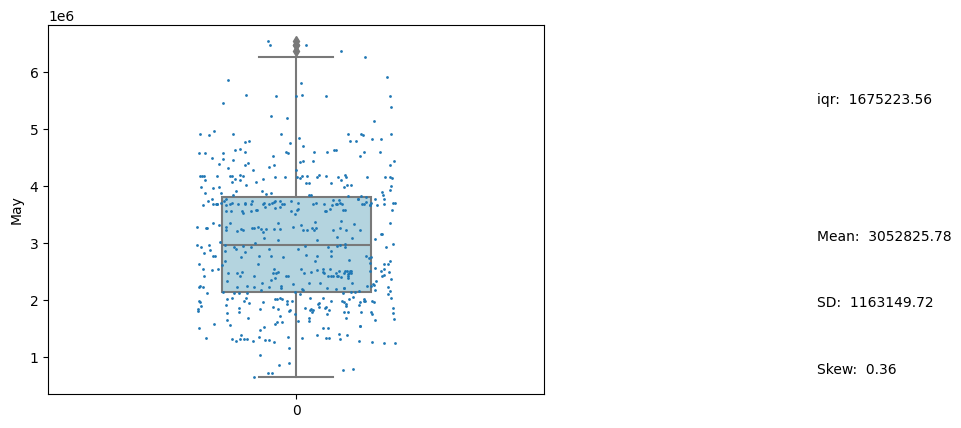

In [54]:
mean = np.mean(generated_data_df['May'])
print('Copula Samples Mean is:', mean)
# Standard Deviation
std_dev = np.std(generated_data_df['May'])
print('Copula STD is', std_dev)

# Skew
skewness = stats.skew(generated_data_df['May'])
print('Skewness', skewness)

# IQR
q75, q25 = np.percentile(generated_data_df['May'], [75, 25])
iqr = q75 - q25
print('Interquartile Range (IQR):', iqr)

sns.boxplot(data=generated_data_df['May'], color='lightblue', width = 0.3)
sns.stripplot(data=generated_data_df['May'], size=2, jitter = 0.2)
plt.text(1.05, mean, f'Mean: {mean: .2f}') #mean 
plt.text(1.05, mean - sd, f'SD: {sd: .2f}')
plt.text(1.05, mean - 2*sd, f'Skew: {skewness: .2f}')
plt.text(1.05, iqr / 2 + median, f'iqr: {iqr: .2f}')

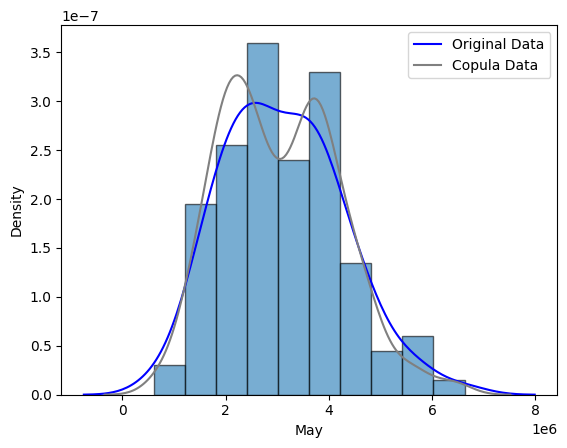

In [55]:
plt.hist(may, density=True, alpha = 0.6, edgecolor = 'black')
sns.kdeplot(may, color='blue', label='Original Data')
sns.kdeplot(data=generated_data_df['May'], color='grey', alpha=1, label = 'Copula Data')
plt.legend()



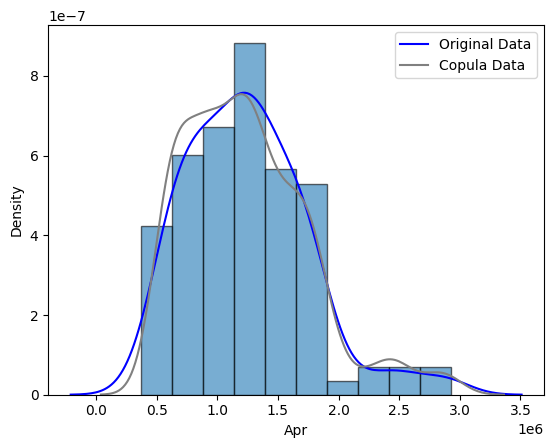

In [56]:
apr = lee_ferry['Apr']
plt.hist(apr, density=True, alpha = 0.6, edgecolor = 'black')
sns.kdeplot(apr, color='blue', label='Original Data')
sns.kdeplot(generated_data_df['Apr'], color='grey', alpha=1, label = 'Copula Data')
plt.legend()

#### Problem 8

In [57]:
chippewa = pd.read_excel('/home/anna/Desktop/Engineering-Probability---Statistics/Chippewa River StreamFlow Data.xls')
chippewa = chippewa.set_index('Year')
chippewa = chippewa.iloc[:111]
chippewa_streamflow = chippewa['StreamFlow'].values

#### A) Gumbel EV-1 Distribution

In [58]:
fit = stats.gumbel_r.fit(chippewa_streamflow)
fit
estimate = stats.gumbel_r.ppf(1 - 1/500, *fit)
estimate

31648.464915056327

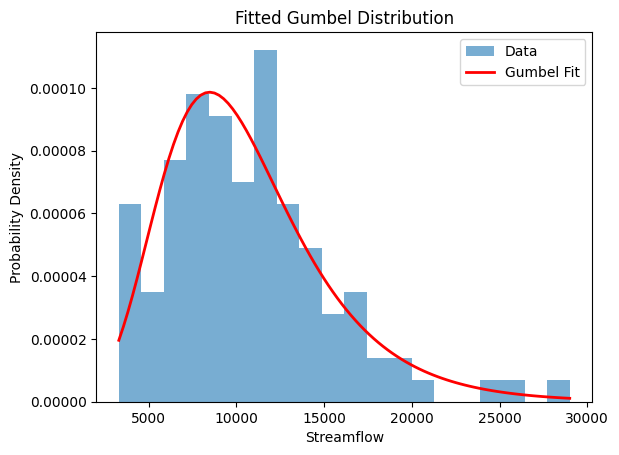

In [59]:
x = np.linspace(min(chippewa_streamflow), max(chippewa_streamflow), 100)
plt.hist(chippewa_streamflow, bins=20, density=True, alpha=0.6, label='Data')

#Plot the fitted Gumbel distribution
plt.plot(x, stats.gumbel_r.pdf(x, *fit), 'r-', lw=2, label='Gumbel Fit')

plt.xlabel('Streamflow')
plt.ylabel('Probability Density')
plt.title('Fitted Gumbel Distribution')
plt.legend()
plt.show()



#### B) Log-Pearson Type 3

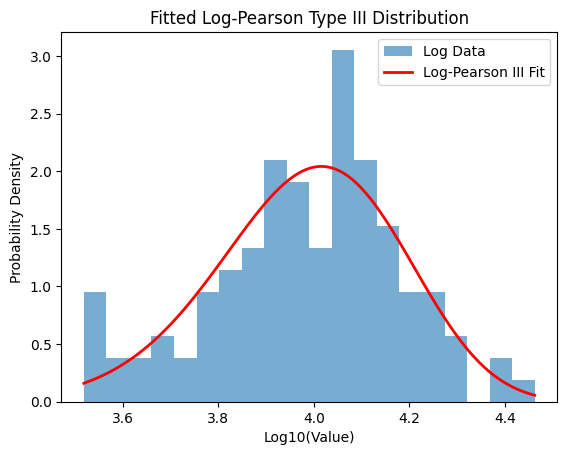

In [60]:
log_data = np.log10(chippewa_streamflow)

# Fit the Pearson Type III distribution to the log-transformed data
shape, loc, scale = stats.pearson3.fit(log_data)

# Generate x values for plotting
x = np.linspace(min(log_data), max(log_data), 100)

# Plot histogram of log-transformed data
plt.hist(log_data, bins=20, density=True, alpha=0.6, label='Log Data')

# Plot the fitted Log-Pearson Type III distribution
plt.plot(x, stats.pearson3.pdf(x, shape, loc, scale), 'r-', lw=2, label='Log-Pearson III Fit')

plt.xlabel('Log10(Value)')
plt.ylabel('Probability Density')
plt.title('Fitted Log-Pearson Type III Distribution')
plt.legend()
plt.show()

In [61]:
log_estimate = stats.pearson3.ppf(1 - 1/500, shape, loc=loc, scale=scale)
estimate = np.exp(log_estimate)
estimate


87.58563247013053

### C) Log Normal

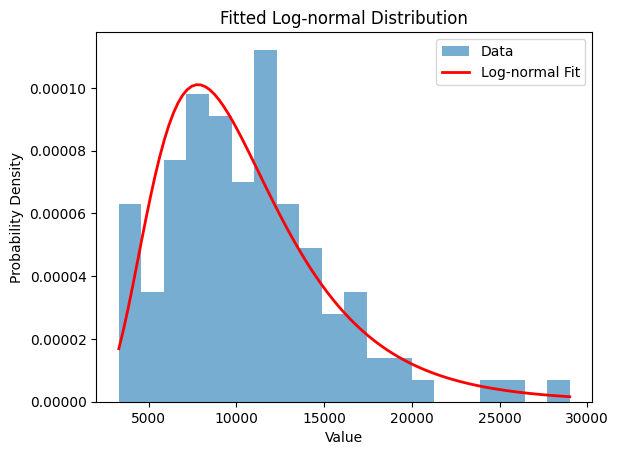

In [62]:
shape, loc, scale = stats.lognorm.fit(chippewa_streamflow, floc=0)

# Generate x values for plotting
x = np.linspace(min(chippewa_streamflow), max(chippewa_streamflow), 100)

# Plot histogram of data
plt.hist(chippewa_streamflow, bins=20, density=True, alpha=0.6, label='Data')

# Plot the fitted log-normal distribution
plt.plot(x, stats.lognorm.pdf(x, shape, loc, scale), 'r-', lw=2, label='Log-normal Fit')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Fitted Log-normal Distribution')
plt.legend()
plt.show()

In [63]:
return_levels = stats.lognorm.ppf(1 - 1/np.array(500), shape, loc, scale)
return_levels

35665.545387581835

### D) Generalized Extreme Value Distributions

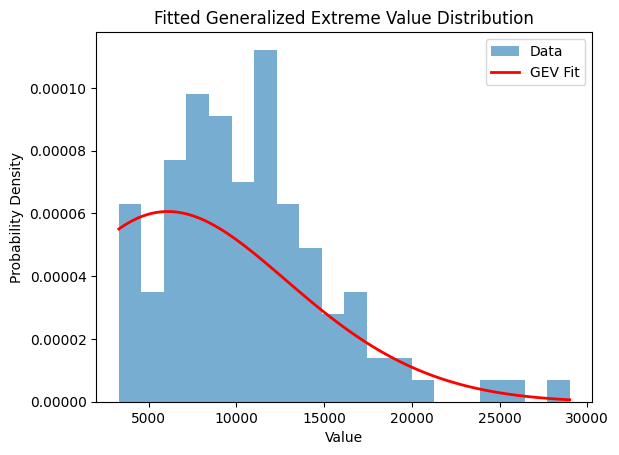

Shape: 0.1811
Location: 4877.0045
Scale: 6175.6374


In [64]:
shape, loc, scale = stats.genextreme.fit(chippewa_streamflow)

# Generate x values for plotting
x = np.linspace(min(chippewa_streamflow), max(chippewa_streamflow), 100)

# Plot histogram of data
plt.hist(chippewa_streamflow, bins=20, density=True, alpha=0.6, label='Data')

# Plot the fitted GEV distribution
plt.plot(x, stats.genextreme.pdf(x, shape, loc, scale), 'r-', lw=2, label='GEV Fit')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Fitted Generalized Extreme Value Distribution')
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Shape: {shape:.4f}")
print(f"Location: {loc:.4f}")
print(f"Scale: {scale:.4f}")

In [65]:
return_levels = stats.genextreme.ppf(1 - 1/np.array(50), shape, loc, scale)
return_levels

22156.259335851704

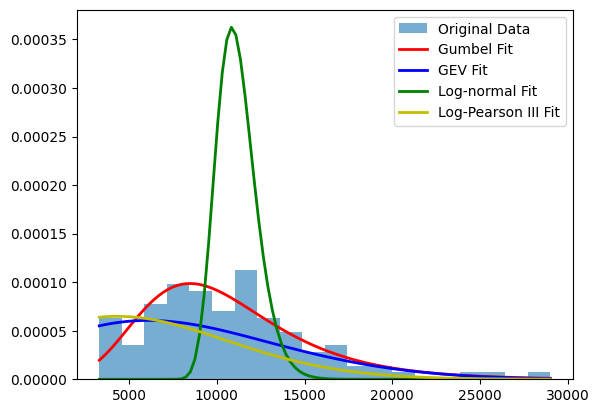

In [66]:
plt.hist(chippewa_streamflow, bins=20, density=True, alpha=0.6, label='Original Data')

#Plot the fitted Gumbel distribution
plt.plot(x, stats.gumbel_r.pdf(x, *fit), 'r-', lw=2, label='Gumbel Fit')
plt.plot(x, stats.genextreme.pdf(x, shape, loc, scale), 'b-', lw=2, label='GEV Fit')
plt.plot(x, stats.lognorm.pdf(x, shape, loc, scale), 'g-', lw=2, label='Log-normal Fit')
plt.plot(x, stats.pearson3.pdf(x, shape, loc, scale), 'y-', lw=2, label='Log-Pearson III Fit')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Pearson Type III Distribution')

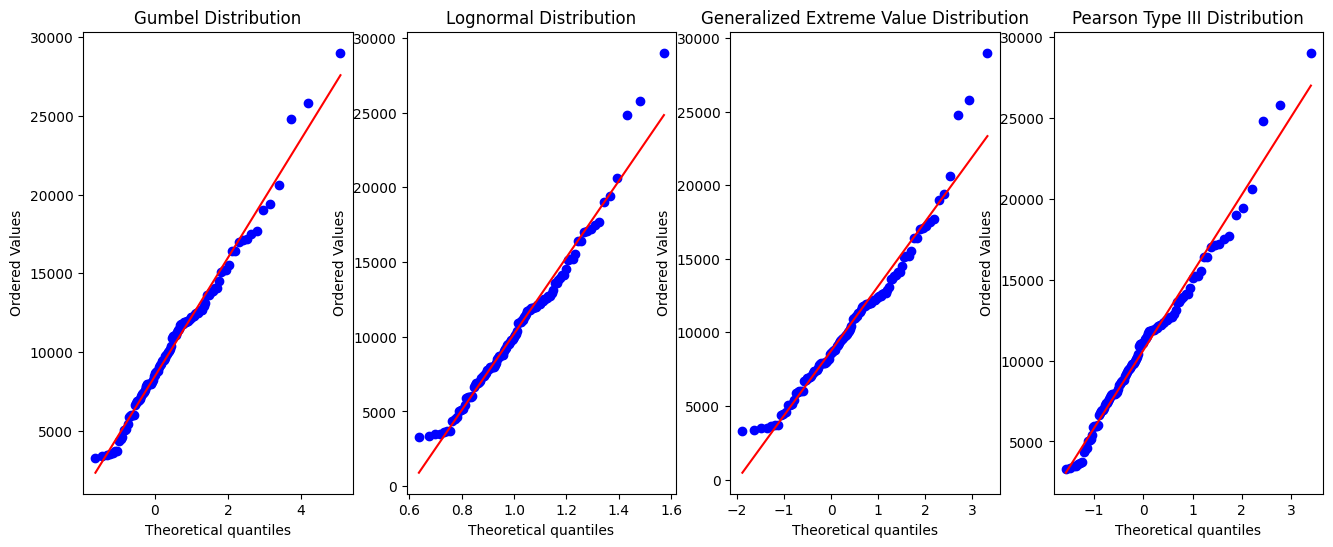

In [67]:
fig, axs = plt.subplots(1, 4, figsize=(16, 6))

# QQ plot for Gamma distribution
stats.probplot(chippewa_streamflow, dist="gumbel_r", plot=axs[0])
axs[0].set_title("Gumbel Distribution")

# QQ plot for Lognormal distribution
stats.probplot(chippewa_streamflow, dist=stats.lognorm(s=shape), plot=axs[1])
axs[1].set_title("Lognormal Distribution")

# QQ plot for Generalized Extreme Value distribution
stats.probplot(chippewa_streamflow, dist=stats.genextreme(shape), plot=axs[2])
axs[2].set_title("Generalized Extreme Value Distribution")

# QQ plot for Pearson Type III distribution
skew = stats.skew(chippewa_streamflow)
stats.probplot(chippewa_streamflow, dist=stats.pearson3(skew), plot=axs[3])
axs[3].set_title("Pearson Type III Distribution")

### Problem 9

In [68]:
h1 = pd.read_excel('US-HurrDamage-Landsea-etal-2018.xlsx')
h2 = h1.set_index(['Year'])
h3 = h2 / 10**9
h4 = h3[(h3['PL18 Sum for Year'] >5) & (h3['CL18 Sum for Year'] >5)]

Shape, loc, and scale parameters for threshold 5 are 0.701393853522982 5.452438566437497 14.25044099673539


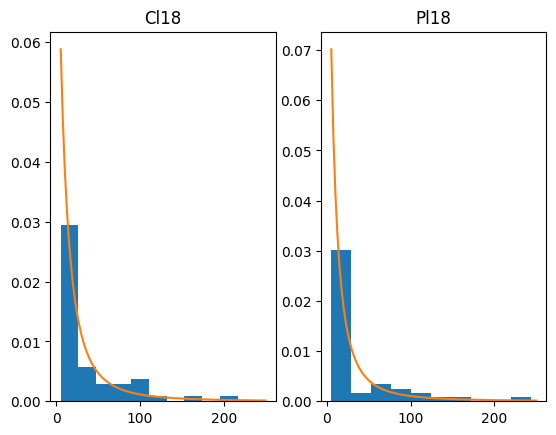

In [69]:
Pl18 = h4['PL18 Sum for Year'].values
Cl18 = h4['CL18 Sum for Year'].values
shape1, loc1, scale1 = genpareto.fit(Pl18)
shape2, loc2, scale2 = genpareto.fit(Cl18)
x1 = np.linspace(loc1, 250, 100)
x2 = np.linspace(loc2, 250, 100)

pdf1 = genpareto.pdf(x1, c=shape1, loc=loc1, scale=scale1)
pdf2 = genpareto.pdf(x2, c=shape2, loc=loc2, scale=scale2)
plt.subplot(1,2,2)
plt.hist(Pl18, density=True)
plt.plot(x1, pdf1)
plt.title('Pl18')
plt.subplot(1,2,1)
plt.hist(Cl18, density = True)
plt.plot(x2, pdf2)
plt.title('Cl18')

print('Shape, loc, and scale parameters for threshold 5 are', shape1, loc1, scale1)

### 100 year return period

In [70]:
T = 100  # in years
p = 1 / T  # Exceedance probability

# Compute the 100-year return level
return_level = stats.genpareto.ppf(1 - p, c=shape1, scale=scale1, loc=loc1)
return_level2 = stats.genpareto.ppf(1 - p, c=shape2, scale=scale2, loc=loc2)

print('Return level for PL18', return_level)
print('Return level for CL18', return_level2)


Return level for PL18 498.7694666792814
Return level for CL18 394.1126733557065


### Model fit with 2 and 6 thresholds

Shape, loc, and scale parameters for threshold 2 are 0.6420592174416839 2.0054881810684257 13.719606469666026


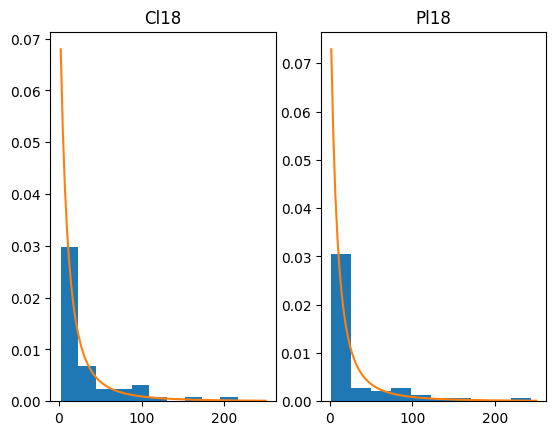

In [71]:
h1 = pd.read_excel('US-HurrDamage-Landsea-etal-2018.xlsx')
h2 = h1.set_index(['Year'])
h3 = h2 / 10**9
h4 = h3[(h3['PL18 Sum for Year'] >2) & (h3['CL18 Sum for Year'] >2)]

Pl18 = h4['PL18 Sum for Year'].values
Cl18 = h4['CL18 Sum for Year'].values
shape1, loc1, scale1 = genpareto.fit(Pl18)
shape2, loc2, scale2 = genpareto.fit(Cl18)
x1 = np.linspace(loc1, 250, 100)
x2 = np.linspace(loc2, 250, 100)

pdf1 = genpareto.pdf(x1, c=shape1, loc=loc1, scale=scale1)
pdf2 = genpareto.pdf(x2, c=shape2, loc=loc2, scale=scale2)
plt.subplot(1,2,2)
plt.hist(Pl18, density=True)
plt.plot(x1, pdf1)
plt.title('Pl18')
plt.subplot(1,2,1)
plt.hist(Cl18, density = True)
plt.plot(x2, pdf2)
plt.title('Cl18')

print('Shape, loc, and scale parameters for threshold 2 are', shape1, loc1, scale1)

Shape, loc, and scale parameters for threshold 6 are 0.6251979254257966 6.317866988214568 16.72424799209314


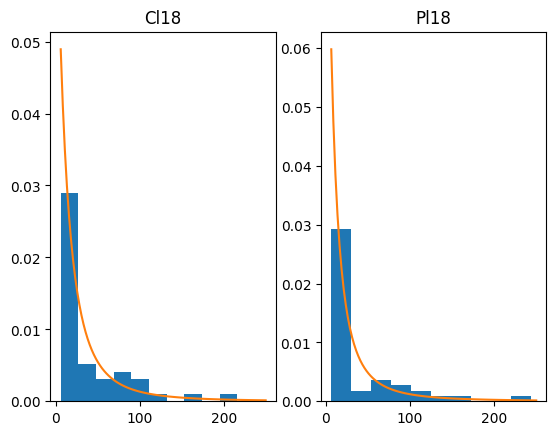

In [72]:
h1 = pd.read_excel('US-HurrDamage-Landsea-etal-2018.xlsx')
h2 = h1.set_index(['Year'])
h3 = h2 / 10**9
h4 = h3[(h3['PL18 Sum for Year'] >6) & (h3['CL18 Sum for Year'] >6)]

Pl18 = h4['PL18 Sum for Year'].values
Cl18 = h4['CL18 Sum for Year'].values
shape1, loc1, scale1 = genpareto.fit(Pl18)
shape2, loc2, scale2 = genpareto.fit(Cl18)
x1 = np.linspace(loc1, 250, 100)
x2 = np.linspace(loc2, 250, 100)

pdf1 = genpareto.pdf(x1, c=shape1, loc=loc1, scale=scale1)
pdf2 = genpareto.pdf(x2, c=shape2, loc=loc2, scale=scale2)
plt.subplot(1,2,2)
plt.hist(Pl18, density=True)
plt.plot(x1, pdf1)
plt.title('Pl18')
plt.subplot(1,2,1)
plt.hist(Cl18, density = True)
plt.plot(x2, pdf2)
plt.title('Cl18')

print('Shape, loc, and scale parameters for threshold 6 are', shape1, loc1, scale1)

#### Sensitivity: How parameters respond to change in threshold

In [73]:
h1 = pd.read_excel('US-HurrDamage-Landsea-etal-2018.xlsx')
h2 = h1.set_index(['Year'])
h3 = h2 / 10**9
h4 = h3[(h3['PL18 Sum for Year'] >8) & (h3['CL18 Sum for Year'] >8)]

Pl18 = h4['PL18 Sum for Year'].values
Cl18 = h4['CL18 Sum for Year'].values
shape1, loc1, scale1 = genpareto.fit(Pl18)
print('Shape, loc, and scale parameters for threshold  are', shape1, loc1, scale1)

Shape, loc, and scale parameters for threshold  are 1.4727607002186403 8.252290736791053 15.215094321032254


In [74]:
def sensitivity(threshold):
    h1 = pd.read_excel('US-HurrDamage-Landsea-etal-2018.xlsx')
    h2 = h1.set_index(['Year'])
    h3 = h2 / 10**9
    h4 = h3[(h3['PL18 Sum for Year'] >threshold) & (h3['CL18 Sum for Year'] >threshold)]
    Pl18 = h4['PL18 Sum for Year'].values
    shape1, loc1, scale1 = genpareto.fit(Pl18)
    return shape1, scale1

shape = []
scale = []
for i in range(50):
    shape_list, scale_list = sensitivity(i)
    shape.append(shape_list)
    scale.append(scale_list)


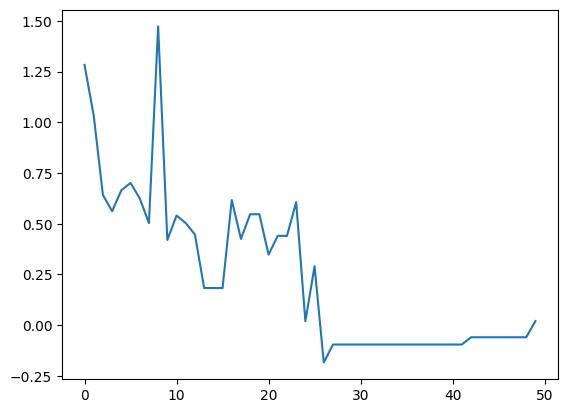

In [75]:
shape
plt.plot(shape)

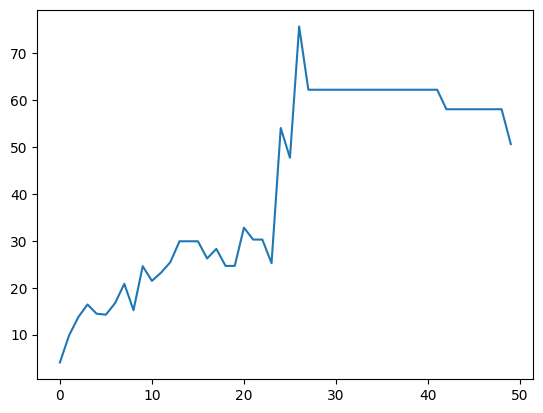

In [76]:
scale
plt.plot(scale)

#### The sensitivity of the model in terms of parameters appears to stabilize around 30. Thus, 30 would be an apt threshold

### Problem 10

In [77]:
india_rainfall = pd.read_csv('allIndia-JJAS-1901-2016.txt', delimiter=' ')
years = np.linspace(1901, 2016, 116)
india_rainfall = india_rainfall.set_index(years)
india_rainfall

V1         V2         V3         V4          V5          V6  \
1901.0  50.730038  36.251213  18.626305   8.563210   69.819901   72.651321   
1902.0  53.193268  36.793221  13.654750   5.371118   81.375824   74.152847   
1903.0  55.505627  38.157845  15.402731   6.673742   83.454140   76.016418   
1904.0  83.346169  57.909809  17.396698   9.458330  103.440170  111.126442   
1905.0  53.142902  32.728706  14.840498   6.329170   95.554611   69.701996   
...           ...        ...        ...        ...         ...         ...   
2012.0  58.516724  58.843525  58.392895  57.485157   57.257030   58.897327   
2013.0  64.629982  46.641991  14.627108   5.494003  107.169350   83.482063   
2014.0  48.813370  38.894375   7.654865   5.693645   97.052872   75.860329   
2015.0  68.234604  45.210030  11.437782   8.278476   83.296730   77.466064   
2016.0  42.394096  23.782433   5.079038   2.270688   56.769825   49.733219   

               V7         V8         V9        V10  ...      V4955      V4956  \
1901.0  17.895527  14.154114   6.651095   2.192934  ...   3.960000   3.960000   
1902.0  14.719666   9.619497   1.118188   2.475685  ...   3.510000   3.510000   
1903.0  17.976551  13.696713   4.596892   2.991419  ...   6.870000   6.870000   
1904.0  24.619595  11.908567   4.438385   3.070257  ...   3.700000   3.700000   
1905.0  12.232794   8.562581   3.331980   0.955363  ...   7.099998   7.099998   
...           ...        ...        ...        ...  ...        ...        ...   
2012.0  61.184883  61.094566  60.110619  57.797810  ...  35.742260  34.666367   
2013.0  44.682327   3.987300   0.453586   0.056011  ...  22.204126  23.692430   
2014.0  38.833107  10.385138   4.264204   2.790398  ...  19.356777  21.262203   
2015.0  36.423687   9.867753   8.843477   1.513240  ...  36.016975  36.704651   
2016.0  23.948360   5.269851   0.083112   0.686532  ...  22.590700  20.415604   

            V4957      V4958      V4959      V4960      V4961      V4962  \
1901.0   3.960000   3.960000   3.960000   3.960000   3.960000   3.960000   
1902.0   3.510000   3.510000   3.510000   3.510000   3.510000   3.510000   
1903.0   6.870000   6.870000   6.870000   6.870000   6.870000   6.870000   
1904.0   3.700000   3.700000   3.700000   3.700000   3.700000   3.700000   
1905.0   7.099998   7.099998   7.099997   7.099997   7.099998   7.099997   
...           ...        ...        ...        ...        ...        ...   
2012.0  33.705070  33.000912  32.798931  33.028633  35.643669  34.668282   
2013.0  25.033182  26.088480  26.806637  27.168320  22.345182  23.693047   
2014.0  22.998552  24.517593  25.867666  27.108761  19.540340  21.263437   
2015.0  37.316612  37.745964  37.901508  37.764965  36.089668  36.711067   
2016.0  18.438427  16.740070  15.381699  14.280124  22.390993  20.418577   

            V4963      V4964  
1901.0   3.960000   3.960000  
1902.0   3.510000   3.510000  
1903.0   6.870000   6.870000  
1904.0   3.700000   3.700000  
1905.0   7.099997   7.099997  
...           ...        ...  
2012.0  33.813923  33.318077  
2013.0  24.882244  25.838352  
2014.0  22.887955  24.382883  
2015.0  37.224102  37.565022  
2016.0  18.565222  16.965670  

[116 rows x 4964 columns]

#### Each column is one .25 x .25 area

In [78]:
lat_lon = pd.read_csv('lon-lat-India-025grid.txt', delimiter=' ', header=None)
lat_lon.columns = ['Longitude', 'Latitude']
lat_lon

Longitude  Latitude
0          8.25     77.00
1          8.25     77.25
2          8.25     77.50
3          8.25     77.75
4          8.50     76.75
...         ...       ...
4959      37.00     75.50
4960      37.25     74.50
4961      37.25     74.75
4962      37.25     75.00
4963      37.25     75.25

[4964 rows x 2 columns]

#### a) Compute the Mann-Kendall Trend in Rainfall at Each Grid and Plot the Trends, along with the statistical significance at 95% confidence level

In [79]:
trend_all = []
p_value_all = []
slope_all = []

for column in india_rainfall:
    grid = np.array(india_rainfall[column].values)
    mk_result = mk.original_test(grid)
    trend = mk_result.trend
    trend_all.append(trend)
    p_value = mk_result.p
    p_value_all.append(p_value)
    slope = mk_result.slope
    slope_all.append(slope)

Text(0.5, 1.0, 'P_value per grid')

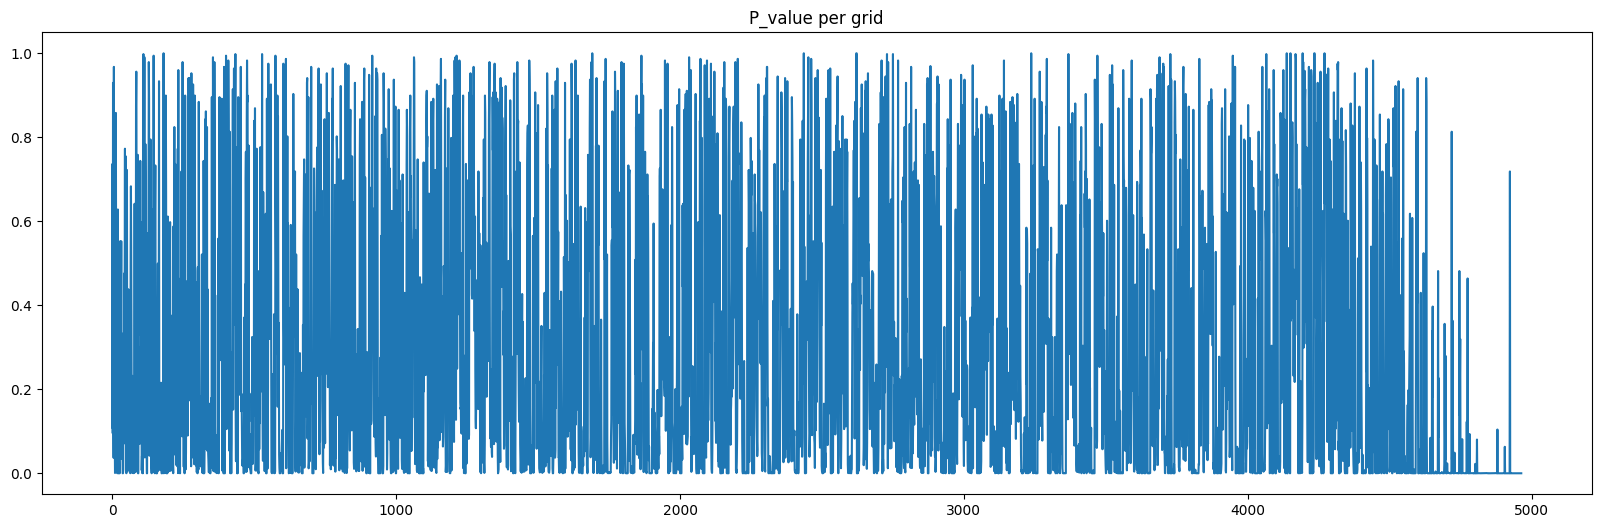

In [80]:
plt.figure(figsize=(20, 6))
sns.lineplot(p_value_all)
plt.title('P_value per grid')

<Axes: ylabel='Count'>

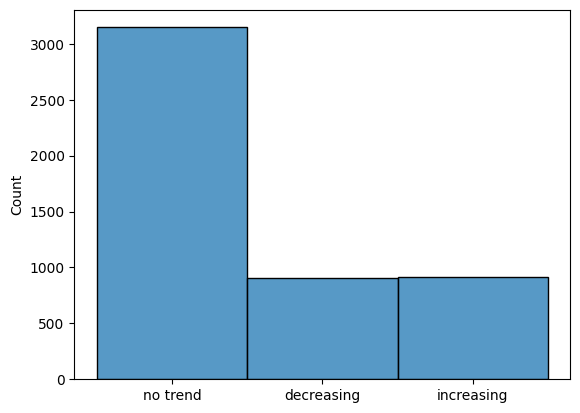

In [81]:
sns.histplot(trend_all)

#### B) Repeat a for the recent period 1980 through 2016

In [82]:
india_rainfall_recent = india_rainfall.iloc[79:116]
india_rainfall_recent

V1         V2         V3         V4          V5          V6  \
1980.0   45.946228  37.137093  13.900354   2.955365   75.537460   63.675270   
1981.0   80.121170  61.490814  12.337578   6.901121  112.682213  112.961288   
1982.0   39.930470  31.801121   2.468921   2.739864   74.334427   63.148415   
1983.0   32.267021  28.619400   1.675267   1.770460   75.608047   51.250141   
1984.0   31.372137  34.499138   6.822138   4.440023   39.076927   54.826458   
1985.0   32.715218  33.814354   4.287132   8.975667   66.197655   54.052185   
1986.0   31.026266  23.087147   1.762356   4.310159   55.392956   41.579708   
1987.0   42.910820  28.745321   8.368188   5.238595   75.393471   51.157814   
1988.0   70.058357  45.484818  11.082533   7.854766  111.763062   82.251884   
1989.0   60.489632  45.362911   7.235189   6.036832  104.965416   94.494339   
1990.0   25.761356  14.324797   1.521117   0.915643   52.646614   35.429878   
1991.0  113.664612  89.544418  35.879215  19.308292  127.173416  111.102318   
1992.0   56.306042  33.818836   8.945215   3.616128  107.072433   78.709282   
1993.0   34.698990  22.276711   4.278777   2.959263   80.963379   55.979980   
1994.0   48.751331  39.859436  20.473454   9.675732   85.580246   69.339684   
1995.0   44.171650  30.221783  10.162600   4.635363   54.164009   54.389172   
1996.0   47.039627  38.597145   8.143302   9.789045   80.724480   57.363972   
1997.0   51.974651  48.662083   6.509529   4.033162  104.453842   80.102707   
1998.0   53.676960  44.554283  20.604883  10.573102   94.234123   68.049942   
1999.0   41.193375  47.830910  10.606395  13.890935   66.450455   52.465923   
2000.0   63.586159  60.115654  32.130043  17.276684   79.946465   58.915642   
2001.0   39.497669  19.579903   1.840266   2.097919  129.402283   56.237537   
2002.0    8.027000   5.000361   0.123771   0.520275   37.098499   16.117168   
2003.0    4.363667   7.962842   0.727561   1.478131   47.519478   20.528131   
2004.0   65.270691  39.028824  27.655743  19.385456   90.859032   73.059067   
2005.0   18.562498  19.379042  18.408308  13.374613   16.636852   15.684111   
2006.0   79.486755  44.291412  12.435965  18.498056   88.801529   90.316246   
2007.0   80.184395  55.645153  19.436512  26.108295  107.639343   95.540474   
2008.0   69.335060  39.265739  10.897104  11.980054   74.895622   73.807587   
2009.0   37.819031  29.602627  10.086691   6.008995   64.749374   57.293068   
2010.0   45.714516  37.674797  10.002745   7.460903   71.317001   64.442474   
2011.0   63.287712  63.939320  62.971272  61.225494   60.086689   63.616028   
2012.0   58.516724  58.843525  58.392895  57.485157   57.257030   58.897327   
2013.0   64.629982  46.641991  14.627108   5.494003  107.169350   83.482063   
2014.0   48.813370  38.894375   7.654865   5.693645   97.052872   75.860329   
2015.0   68.234604  45.210030  11.437782   8.278476   83.296730   77.466064   
2016.0   42.394096  23.782433   5.079038   2.270688   56.769825   49.733219   

                V7         V8         V9        V10  ...      V4955  \
1980.0   46.654930   2.435752   5.742099   1.793650  ...  35.766151   
1981.0   82.920547  13.452353   7.741923   6.164375  ...  27.464319   
1982.0   43.867989   6.277899   4.272225   1.965598  ...  17.352112   
1983.0   38.969841   5.923909   2.340945   1.546120  ...  31.296261   
1984.0   42.128773   8.411811   6.207613   1.242876  ...  28.882807   
1985.0   57.616650   8.874224   7.740505   6.800162  ...  14.675407   
1986.0   38.068512   8.627912   2.518338   3.301237  ...  17.806604   
1987.0   41.771744   8.495943   6.949023   1.579894  ...   7.721274   
1988.0   68.369980  13.661746  10.243135   1.570557  ...  61.375164   
1989.0   75.461685  10.847754   9.349998   0.836031  ...  40.041164   
1990.0   35.876308   2.243355   1.288017   0.131329  ...  17.425440   
1991.0   82.335861  26.409695  19.454264   3.315456  ...   6.222333   
1992.0   71.836479  13.538233   2.707636   0.273862  ...  65.686020   
1993.0   55.108452 

In [83]:
trend_all = []
p_value_all = []
slope_all = []

for column in india_rainfall_recent:
    grid = np.array(india_rainfall_recent[column].values)
    mk_result = mk.original_test(grid)
    trend = mk_result.trend
    trend_all.append(trend)
    p_value = mk_result.p
    p_value_all.append(p_value)
    slope = mk_result.slope
    slope_all.append(slope)

Text(0.5, 1.0, 'P_value per grid')

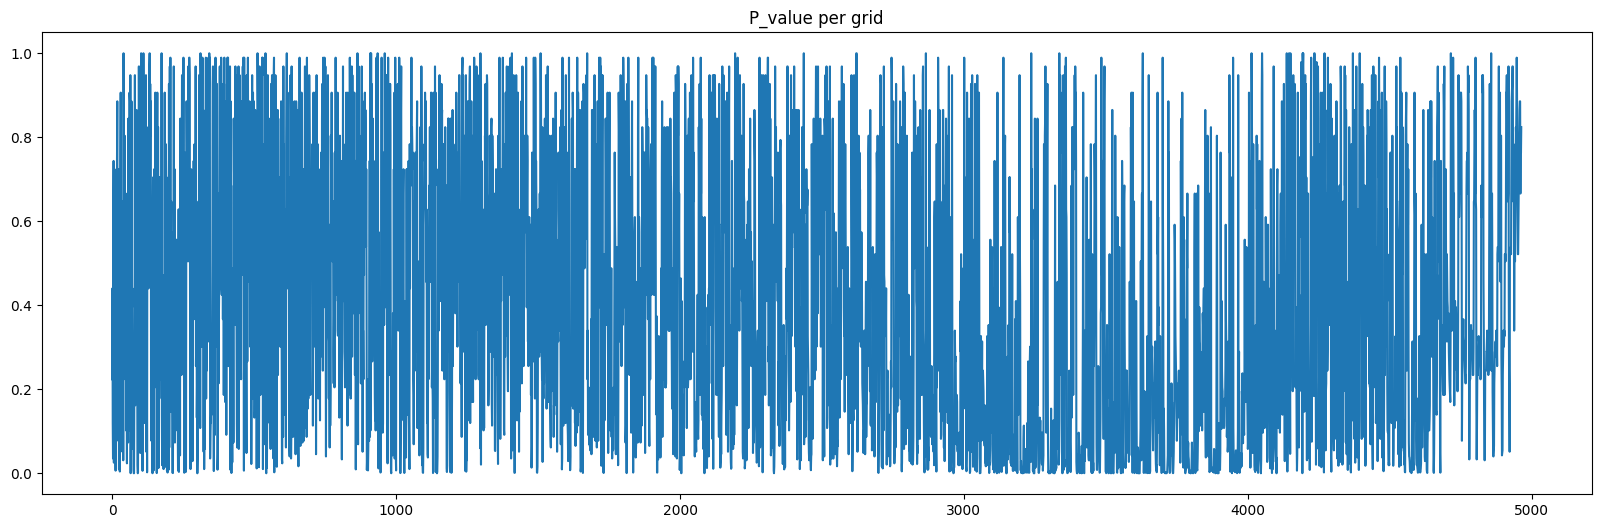

In [84]:
plt.figure(figsize=(20, 6))
sns.lineplot(p_value_all)
plt.title('P_value per grid')

<Axes: ylabel='Count'>

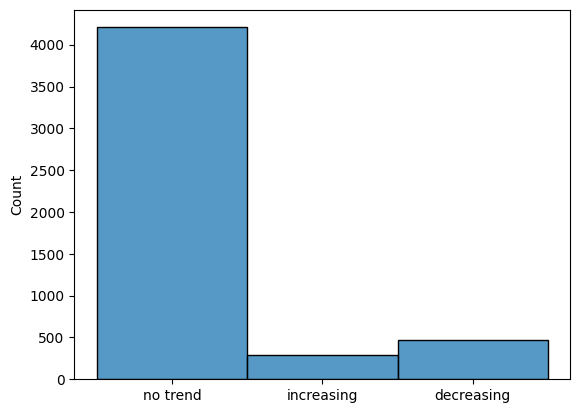

In [85]:
sns.histplot(trend_all)

### there is a higher proportion of decreasing trends, a lower portion of increasing trends, and a higher prortion of no trend from 1980 - 2016

### (C) Correlate summer ENSO index with summer season rainfall at each grid and spatially map the correltation values. Do this for the entire period and recent period

In [120]:
india_rainfall = pd.read_csv('allIndia-JJAS-1901-2016.txt', delimiter=' ')
ensoindex = np.loadtxt('NINO34-JJAS-average-1906-2016.txt')
correlation = india_rainfall.corrwith(pd.Series(ensoindex))
correlation


V1      -0.058595
V2      -0.053660
V3       0.059715
V4       0.119865
V5       0.033566
           ...   
V4960    0.200839
V4961    0.137753
V4962    0.152985
V4963    0.167125
V4964    0.179708
Length: 4964, dtype: float64

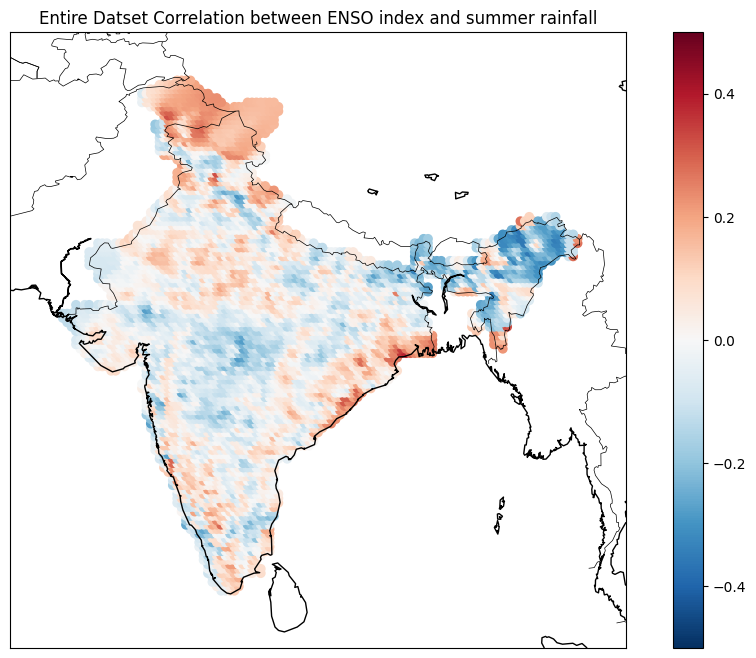

In [121]:
plt.figure(figsize=(12, 8))
m = Basemap(llcrnrlon=65, llcrnrlat=5, urcrnrlon=100, urcrnrlat=40, resolution='l')
m.drawcoastlines()
m.drawcountries()
sc = m.scatter(lat_lon['Latitude'], lat_lon["Longitude"], c=correlation, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
plt.colorbar(sc)
plt.title('Entire Datset Correlation between ENSO index and summer rainfall')
plt.show()

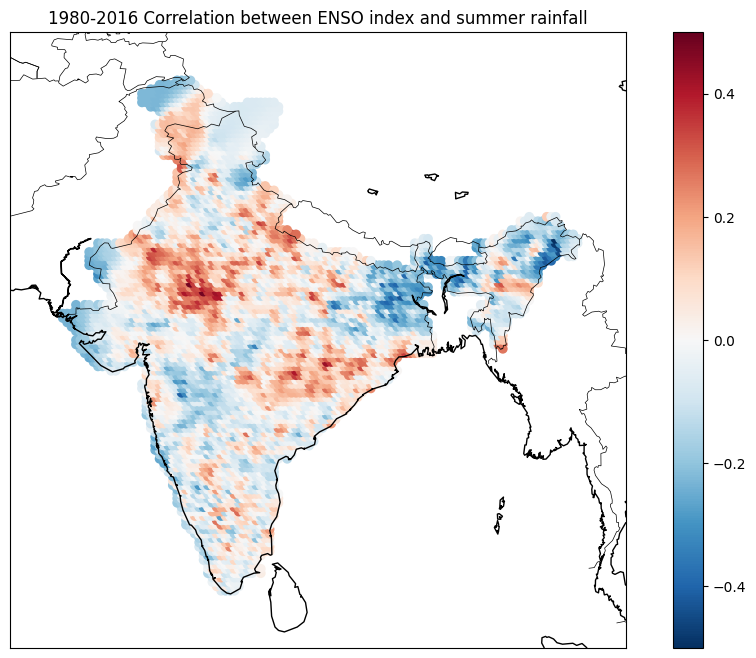

In [122]:
ensoindex = np.loadtxt('NINO34-JJAS-average-1906-2016.txt')

india_rainfall_recent = india_rainfall.iloc[79:116]
india_rainfall_recent

correlation = india_rainfall_recent.corrwith(pd.Series(ensoindex))
correlation

plt.figure(figsize=(12, 8))
m = Basemap(llcrnrlon=65, llcrnrlat=5, urcrnrlon=100, urcrnrlat=40, resolution='l')
m.drawcoastlines()
m.drawcountries()
sc = m.scatter(lat_lon['Latitude'], lat_lon["Longitude"], c=correlation, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
plt.colorbar(sc)
plt.title('1980-2016 Correlation between ENSO index and summer rainfall')
plt.show()

### d) Compute all india rainfall. Select the top 10% years with high rainfall and the bottom 10% with low rainfall. Compute the rainfall average over these years at each grid point and plot them as spatial maps for the high and low rainfall years seperately. These are called 'Composite' maps and will show the spatial pattern of rainfall during an all india wet or all india dry year

In [89]:
rainfall_sum = pd.DataFrame(india_rainfall.sum(axis = 1))
rainfall_sum.columns = ['Rainfall']
rainfall_sum_df = rainfall_sum.sort_values(by='Rainfall')
rainfall_sum
# india_rainfall


Rainfall
1901.0  366481.871451
1902.0  393284.465366
1903.0  425838.578028
1904.0  369152.822739
1905.0  355916.966799
...               ...
2012.0  412547.894697
2013.0  459690.894257
2014.0  380735.795012
2015.0  379149.423589
2016.0  423867.943546

[116 rows x 1 columns]

In [90]:
#Top 10% of 116 rows is ~top 12 and bottom twelve rows
india_rainfall_bottom_ten = rainfall_sum_df.iloc[0:11]
india_rainfall_top_ten = rainfall_sum_df.iloc[105:116]
india_rainfall_top_ten


Rainfall
1994.0  469209.479552
1970.0  471209.326068
1916.0  472689.818231
1959.0  475243.336945
1942.0  477813.067302
1983.0  478218.887140
1933.0  486348.132600
1961.0  490948.388437
1975.0  493833.060795
1988.0  500541.421429
1917.0  506654.657585

In [91]:
# average_bottom = india_rainfall_bottom_ten / 4964
# average_bottom = np.array(average_bottom)
# average_top = india_rainfall_bottom_ten / 4964
# average_top = np.array(average_top)
# average_top
bottom = india_rainfall_bottom_ten.join(india_rainfall)
bottom = bottom.drop('Rainfall', axis = 1)
bottom = bottom.mean()
top = india_rainfall_top_ten.join(india_rainfall)
top = top.drop('Rainfall', axis = 1)
top = top.mean()
top

V1       62.399903
V2       47.510405
V3       14.388475
V4        7.919848
V5       97.068319
           ...    
V4960    25.380386
V4961    39.943183
V4962    36.649006
V4963    33.498949
V4964    30.599373
Length: 4964, dtype: float64

In [92]:
bottom

V1       53.497521
V2       40.077467
V3       10.232638
V4        6.358588
V5       76.780305
           ...    
V4960    16.076716
V4961    21.164491
V4962    20.209163
V4963    19.156270
V4964    18.076583
Length: 4964, dtype: float64

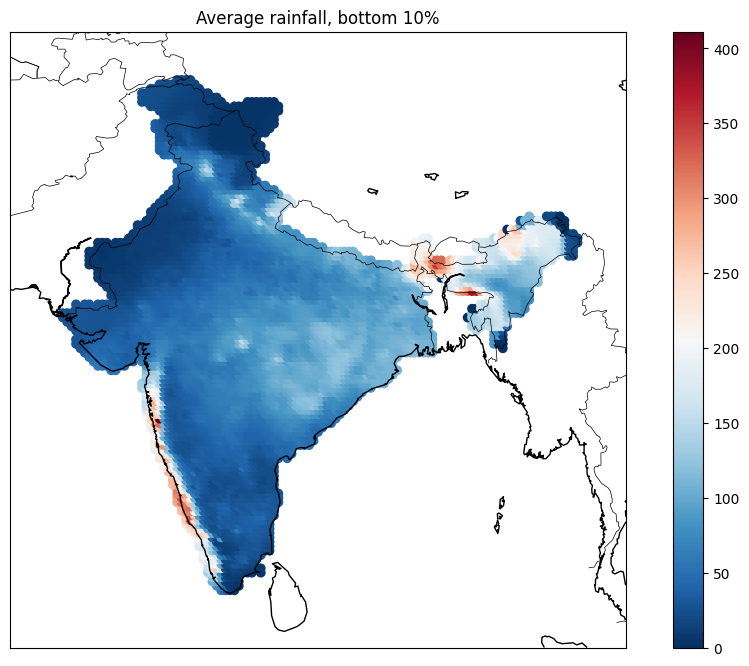

In [93]:
plt.figure(figsize=(12, 8))
m = Basemap(llcrnrlon=65, llcrnrlat=5, urcrnrlon=100, urcrnrlat=40, resolution='l')
m.drawcoastlines()
m.drawcountries()
sc = m.scatter(lat_lon['Latitude'], lat_lon["Longitude"], c=bottom, cmap='RdBu_r', vmin=bottom.min(), vmax=bottom.max())
plt.colorbar(sc)
plt.title('Average rainfall, bottom 10%')
plt.show()

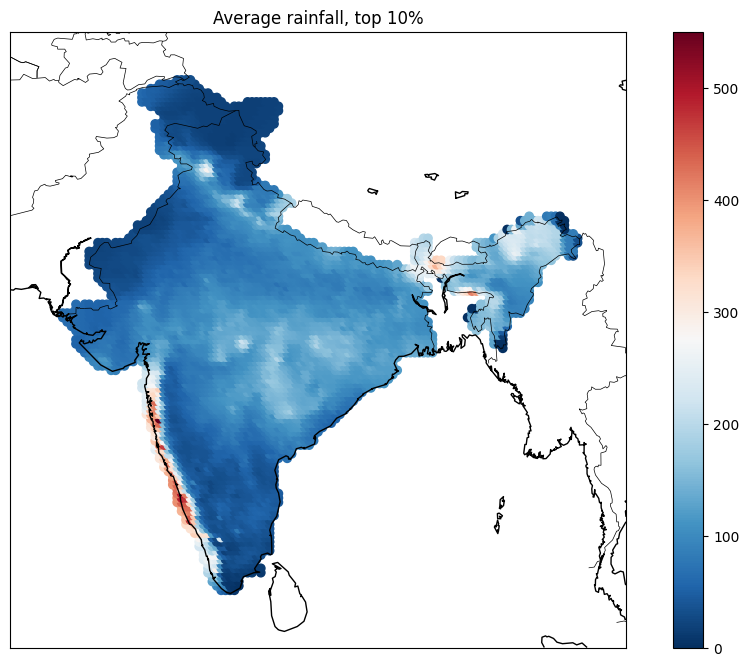

In [94]:
plt.figure(figsize=(12, 8))
m = Basemap(llcrnrlon=65, llcrnrlat=5, urcrnrlon=100, urcrnrlat=40, resolution='l')
m.drawcoastlines()
m.drawcountries()
sc = m.scatter(lat_lon['Latitude'], lat_lon["Longitude"], c=top, cmap='RdBu_r', vmin=top.min(), vmax=top.max())
plt.colorbar(sc)
plt.title('Average rainfall, top 10%')
plt.show()

### Problem 11) 

#### (A) Scatterplot spring flow with all the potential predictor variables and apply a default smoother in R to smooth the scatterplot and comment on the relationships you see (linear, nonlinear etc.).

In [95]:
spring_flow = lee_ferry[['Apr', 'May', 'June', 'July']]
spring_flow.reset_index(inplace=True)
El_Nino = pd.read_csv('NINO34-summer-1906-2016.txt', delimiter=' ', header=None)
El_Nino.columns = ['Southern_Oscillation']
spring_flow = spring_flow.drop('Year', axis = 1)

In [96]:
combined_all = pd.concat([El_Nino, spring_flow], axis=1)
combined_all

Southern_Oscillation      Apr      May     June     July
0                0.110350  1204640  3635101  5014167  2950460
1                0.529225  1465838  2702179  5967232  5103491
2               -0.414587  1041224  1595614  2922360  1924283
3               -0.254512  1120492  3349297  7203254  4109919
4               -0.872450  1730475  3298793  3101705  1373125
..                    ...      ...      ...      ...      ...
106              0.626923  1222586  1362700  1079225   744933
107             -0.086700   546319  1965060  1964812   874772
108              0.446367  1269132  2932034  3933465  1527985
109              1.973837   852287  2115387  4265586  1651282
110             -0.038885  1099567  2967581  3910287  1342044

[111 rows x 5 columns]

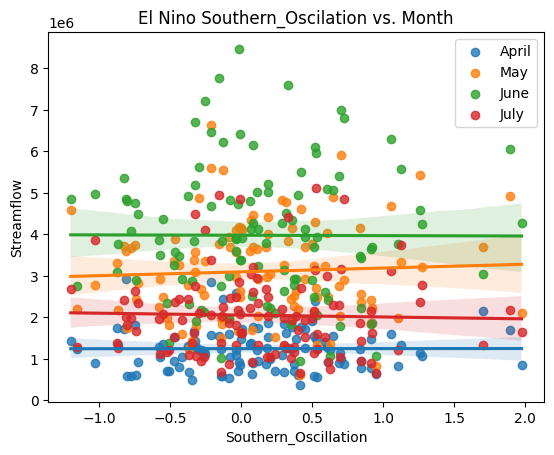

In [97]:
sns.regplot(x='Southern_Oscillation', y='Apr', data = combined_all, label='April')
sns.regplot(x='Southern_Oscillation', y='May', data = combined_all, label = 'May')
sns.regplot(x='Southern_Oscillation', y='June', data = combined_all, label = 'June')
sns.regplot(x='Southern_Oscillation', y='July', data = combined_all, label = 'July')
plt.title('El Nino Southern_Oscilation vs. Month')
plt.ylabel('Streamflow')
plt.legend()


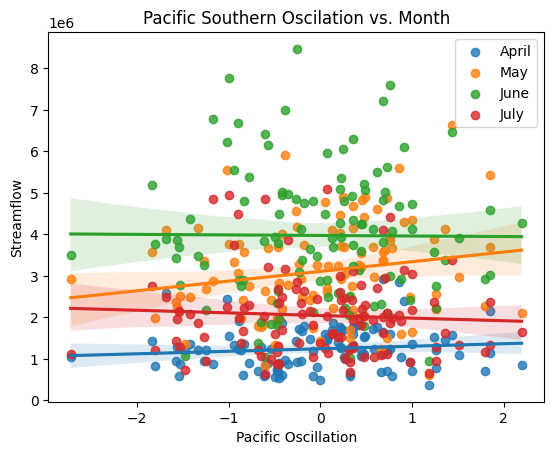

In [98]:
PDO = pd.read_csv('PDO-winter-1906-2016.txt', delimiter=' ', header=None)
PDO.fillna(0)
PDO = pd.DataFrame(PDO.stack())
PDO.reset_index(inplace=True)
PDO = PDO.drop(['level_0', 'level_1'], axis = 1)
PDO.columns = ['Pacific Oscillation']
PDO
combined = pd.concat([PDO, spring_flow], axis=1)
combined
sns.regplot(x='Pacific Oscillation', y='Apr', data = combined, label='April')
sns.regplot(x='Pacific Oscillation', y='May', data = combined, label = 'May')
sns.regplot(x='Pacific Oscillation', y='June', data = combined, label = 'June')
sns.regplot(x='Pacific Oscillation', y='July', data = combined, label = 'July')
plt.title('Pacific Southern Oscilation vs. Month')
plt.ylabel('Streamflow')
plt.legend()


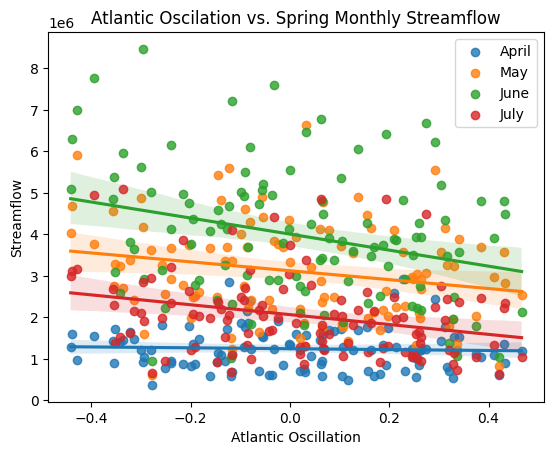

In [99]:
AMO = pd.read_csv('AMO-winter-1906-2016.txt', delimiter=' ', header=None)
AMO.fillna(0)
AMO = pd.DataFrame(AMO.stack())
AMO.reset_index(inplace=True)
AMO = AMO.drop(['level_0', 'level_1'], axis = 1)
AMO.columns = ['Atlantic Oscillation']
AMO
combined = pd.concat([AMO, spring_flow], axis=1)
combined
sns.regplot(x='Atlantic Oscillation', y='Apr', data = combined, label='April')
sns.regplot(x='Atlantic Oscillation', y='May', data = combined, label = 'May')
sns.regplot(x='Atlantic Oscillation', y='June', data = combined, label = 'June')
sns.regplot(x='Atlantic Oscillation', y='July', data = combined, label = 'July')
plt.title('Atlantic Oscilation vs. Spring Monthly Streamflow')
plt.ylabel('Streamflow')
plt.legend()

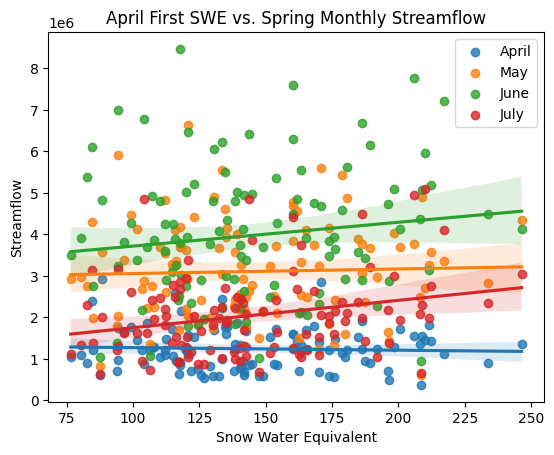

In [100]:
SWE = pd.read_csv('Mar1-and-Apr1-SWE-1906-2016.txt', delimiter=' ', header=None)
SWE.fillna(0)
SWE = pd.DataFrame(SWE.stack())
SWE.reset_index(inplace=True)
SWE = SWE.drop(['level_0', 'level_1'], axis = 1)
SWE.columns = ['Snow Water Equivalent']
SWE
combined = pd.concat([SWE, spring_flow], axis=1)
combined
sns.regplot(x='Snow Water Equivalent', y='Apr', data = combined, label='April')
sns.regplot(x='Snow Water Equivalent', y='May', data = combined, label = 'May')
sns.regplot(x='Snow Water Equivalent', y='June', data = combined, label = 'June')
sns.regplot(x='Snow Water Equivalent', y='July', data = combined, label = 'July')
plt.title('April First SWE vs. Spring Monthly Streamflow')
plt.ylabel('Streamflow')
plt.legend()

#### El Nino and PSO have no real relationship. AO has a slight negative relationship, and SWE has a slight positive relationship 

#### Subsequent parts of 11 are on seperate upload. 